# Sensitivity of Synthetic Data to Modeling Parameters


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import itertools
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from pathlib import Path
home = str(Path.home())
import sys
sys.path.insert(0,"%s/sensitivity_study/src"%home)
from experiment import read_raw_pairwise, construct_support_matrix, get_features_from_support, get_target_stability, eval_models
from sensitivity_tests import *
import utilities

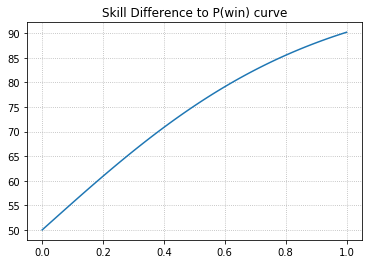

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

ELO_scale = 0.45

xs = np.linspace(0.0, 1.0, endpoint=True, num=100)
ys = sigmoid(xs/ELO_scale)*100.0

plt.grid(True, axis="both", which="both", linestyle=":")
plt.plot(xs, ys)
plt.title("Skill Difference to P(win) curve")
plt.show()

In [4]:
# This number of games and number of teams were both selected
# to match the NBA regular season
def generate_synth_games(n_games=1230, n_teams=30, n_pts=64, elo_scale=ELO_scale):
    # Columns are team1, team2, points1, points2, date
    df = {
        "team1":[],
        "team2":[],
        "team1_name":[],
        "team2_name":[],
        "team1_select":[],
        "team2_select":[],
        "team1_score":[],
        "team2_score":[]
    }
    all_teams = range(n_teams)
    all_skills = np.linspace(0.0, 1.0, endpoint=True, num=n_teams)
    for date in range(n_games):
        t1 = date % n_teams
        t2 = t1
        while t2 == t1:
            t2 = random.choice(all_teams)
        scaled_elo_diff = (all_skills[t1] - all_skills[t2])/ELO_scale
        prob_t1_win = sigmoid(scaled_elo_diff)
        t1_pts = n_pts*np.random.binomial(n=1, p=prob_t1_win)
        t2_pts = n_pts - t1_pts
        df["team1"].append(t1)
        df["team2"].append(t2)
        df["team1_name"].append(str(t1))
        df["team2_name"].append(str(t2))
        df["team1_select"].append(1)
        df["team2_select"].append(1)
        df["team1_score"].append(t1_pts)
        df["team2_score"].append(t2_pts)
    return pd.DataFrame(df)

In [5]:
games = []
scales = []
num_tournaments = 75
ELO_scales = [0.2, 0.3, 0.4, 0.5]
for elo_scale in ELO_scales:
    for tourny_num in range(num_tournaments):
        games.append(generate_synth_games())
        scales.append(elo_scale)
games = {idx:game for idx,game in enumerate(games)}
years = list(games.keys())
games[years[-1]]

team1  team2 team1_name team2_name  team1_select  team2_select  \
0         0     12          0         12             1             1   
1         1      4          1          4             1             1   
2         2     17          2         17             1             1   
3         3     26          3         26             1             1   
4         4      2          4          2             1             1   
...     ...    ...        ...        ...           ...           ...   
1225     25      7         25          7             1             1   
1226     26     29         26         29             1             1   
1227     27     15         27         15             1             1   
1228     28     11         28         11             1             1   
1229     29     19         29         19             1             1   

      team1_score  team2_score  
0               0           64  
1               0           64  
2               0           64  
3               0           64  
4              64            0  
...           ...          ...  
1225           64            0  
1226            0           64  
1227           64            0  
1228           64            0  
1229            0           64  

[1230 rows x 8 columns]

In [6]:
load = False
# TODO: measure sensitivity of massey & colley to S construction params

config = {
    "col_mapping": {
        "team1_name":"team1_name",
        "team1_score":"team1_score",
        "team2_name":"team2_name",
        "team2_score":"team2_score",
        "team1_select": "team1_select",
        "team2_select": "team2_select",
        "date":"date"
    },
    "rankingMethods": [MasseyRankingAlgorithm(), ColleyRankingAlgorithm()],
    "correlationMethod":utilities.kendall_tau,
    "fracs": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "n_restarts": 5,
    "direct_thres": [0], # Since pts are constant (winner takes all in this simulation)
    "spread_thres": [0], # Both of these parameters do nothing.
    "weight_indirect": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "raw_filepaths": ["{}/sensitivity_study/data/MarchMadnessDataFrames/march_madness_{}.csv".format(home,yr) for yr in years],
    "model_list": [{"model":DummyRegressor(), "param_grid": {}},
                   {"model":LinearRegression(), "param_grid": {'fit_intercept': [True, False]}}]
}

In [7]:
df = {"fp":[], "frac":[], "method":[], "w":[], "elo_scale":[]}
support_matricies = {}
rankings_by_method = {}
feature_df_list = []
# For each raw file (equivalent to a season / tournament / single scenario)
# get feature vector and target scalar
num_matrices = len(games.keys()) * len(config["fracs"]) * len(config["direct_thres"]) \
               * len(config["spread_thres"]) * len(config["weight_indirect"])
with tqdm(total=num_matrices) as pbar:
    for elo_scale, fp in zip(scales, games.keys()):
        for frac in config["fracs"]:
            support_matricies[(fp, frac)] = []
            rankings_by_method[(fp, frac)] = {r.__class__.__name__: [] for r in config["rankingMethods"]}

            for d_thresh, s_thresh, w_ind in itertools.product(config["direct_thres"],
                                                               config["spread_thres"],
                                                               config["weight_indirect"]):
                support_mat = construct_support_matrix(games[fp],
                                                       frac,
                                                       direct_thres=d_thresh,
                                                       spread_thres=s_thresh,
                                                       weight_indirect=w_ind)
                support_matricies[(fp, frac)].append(support_mat)
                # get rankings for support for all ranking methods
                for rankingMethod in config["rankingMethods"]:
                    rankings_by_method[(fp, frac)][rankingMethod.__class__.__name__].append(rankingMethod.rank(support_mat.fillna(0).values))
                pbar.update(1)

            for methodName, rankings in rankings_by_method[(fp, frac)].items():
                #df["fp"].append(fp[-8:-4])
                df["fp"].append(fp)
                df["elo_scale"].append(elo_scale)
                df["frac"].append(frac)
                df["method"].append(methodName)
                df["w"].append(kendall_w(rankings)[1])

df = pd.DataFrame(df)

100%|██████████| 33000/33000 [5:15:49<00:00,  1.74it/s]  


In [8]:
df.to_csv("synth_sensitivity_to_modeling_parameters2.csv", index=False)

with open("synth_support_mats2.pickle","wb") as p_file:
    pickle.dump(support_matricies, p_file)

## Read in saved data

If you already have a saved dataset available, the cell below can read them from their .csv and .pickle locations. If you want this cell to do anything, you must manually change `load = False` to `load = True` and ensure that the provided filepaths are correct.

In [9]:
load = False

if load:
    df = pd.read_csv("synth_sensitivity_to_modeling_parameters.csv")

    with open("synth_support_mats.pickle","rb") as p_file:
        support_matricies = pickle.load(p_file)

## Plots to Draw

1. Plot the trends in w over fractions for a particular method (and repeat with many such trends on the same plot each with a different ELO_scale)
2. Plot w per elo_scale and frac (comparison of methods for each value)

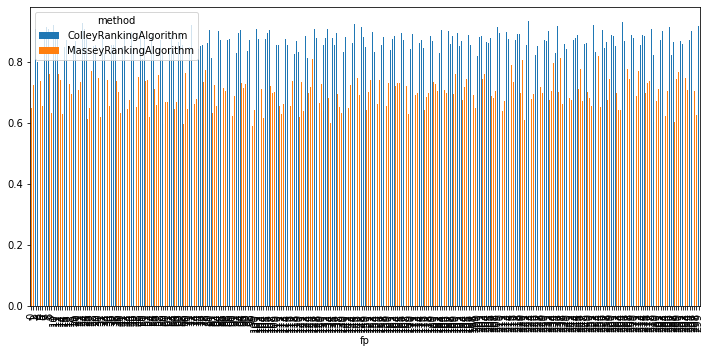

In [10]:
df.groupby(["fp", "method"])["w"].mean().unstack().plot.bar(figsize=(12,5.5))

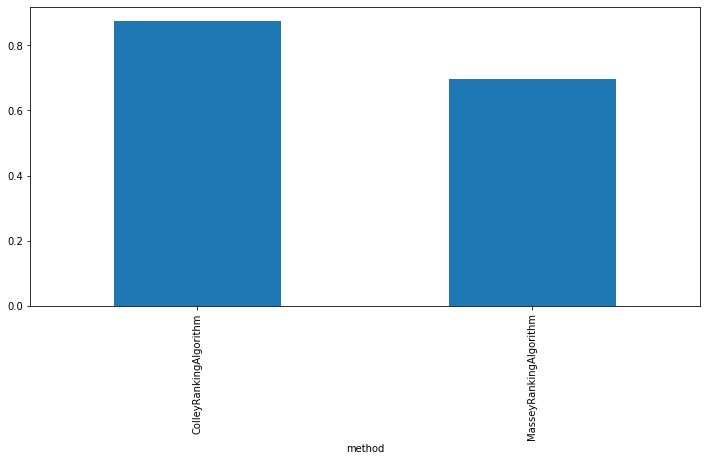

In [11]:
df.groupby(["method"])["w"].mean().plot.bar(figsize=(12,5.5))

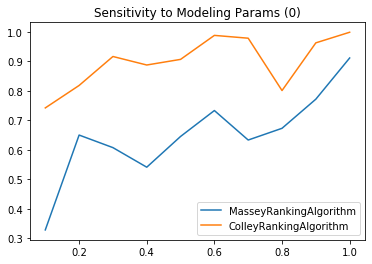

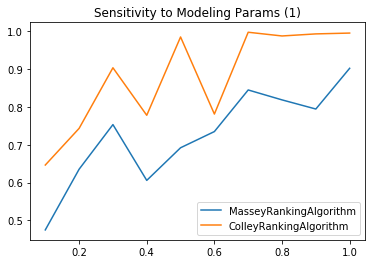

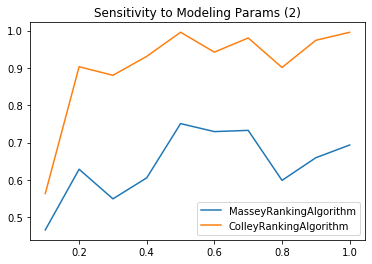

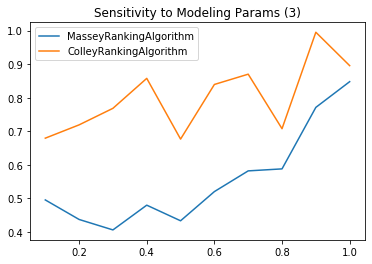

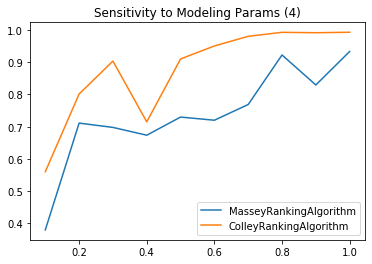

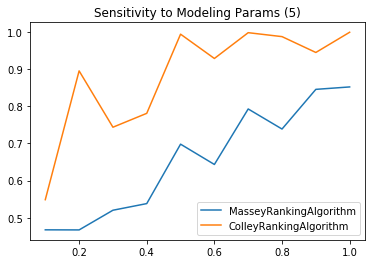

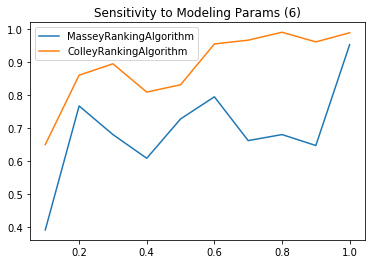

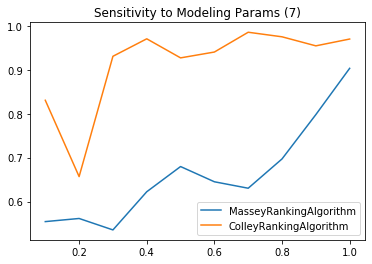

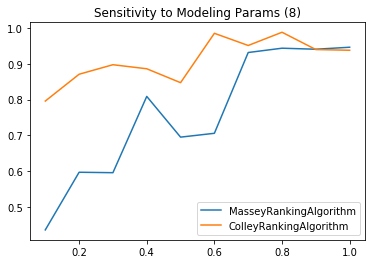

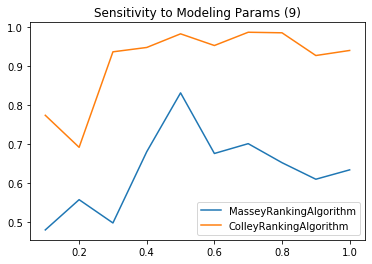

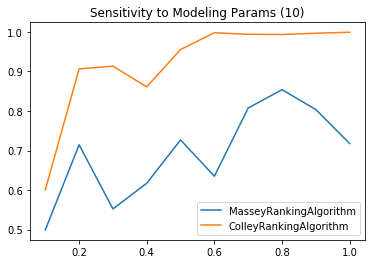

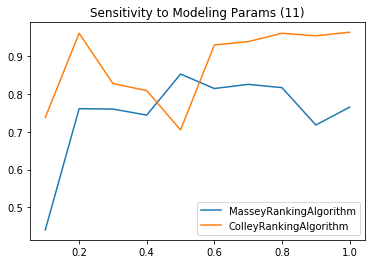

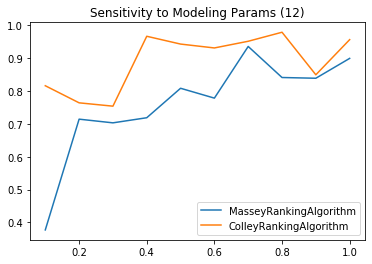

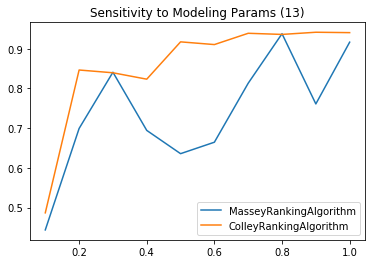

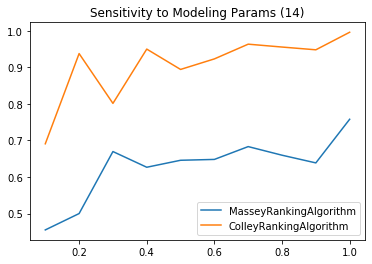

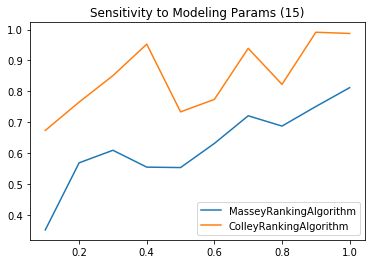

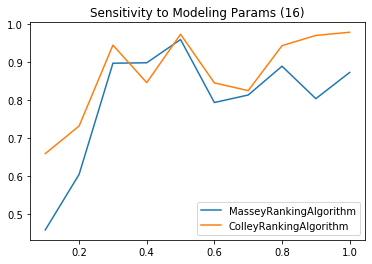

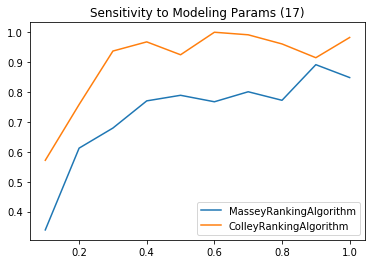

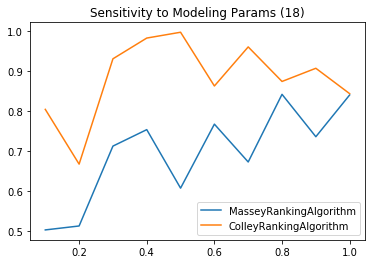

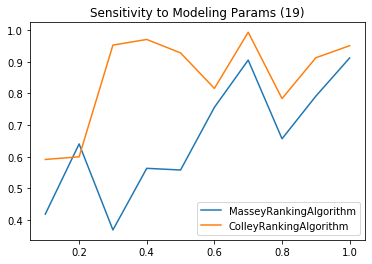

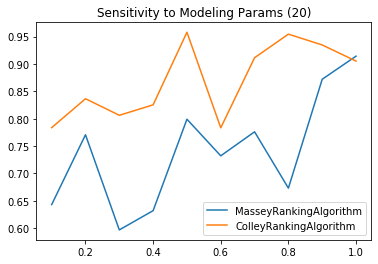

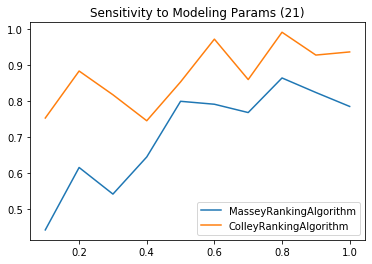

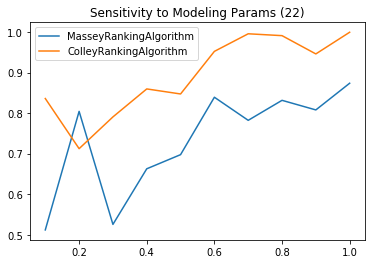

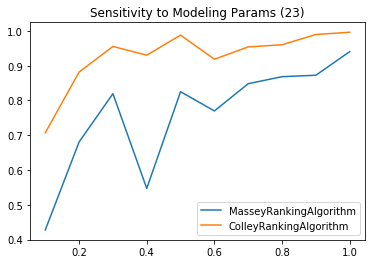

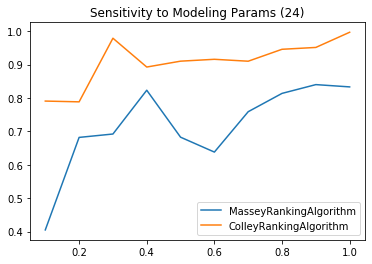

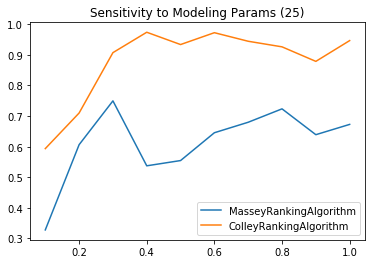

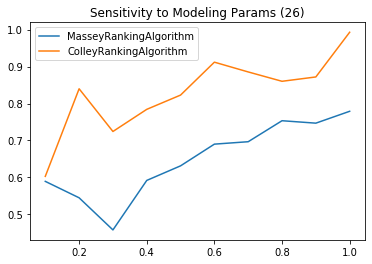

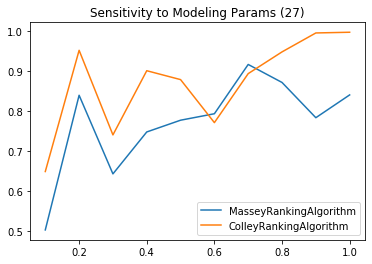

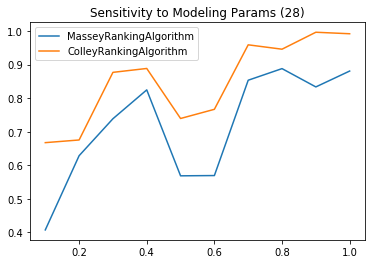

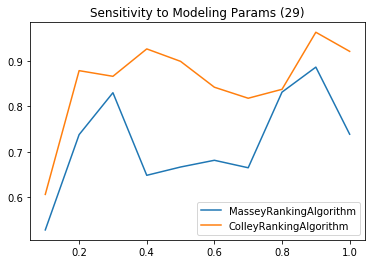

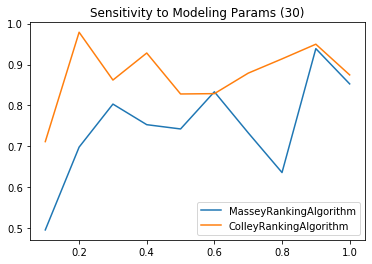

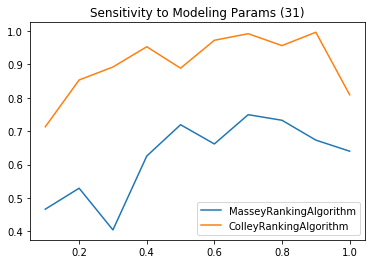

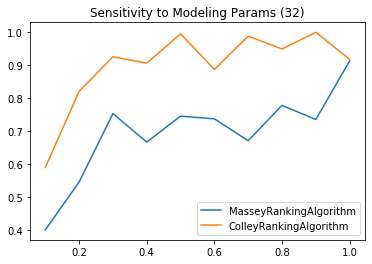

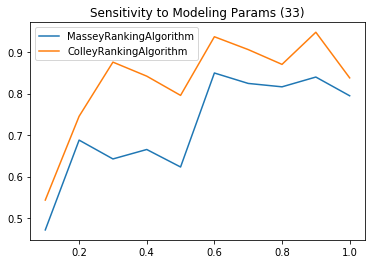

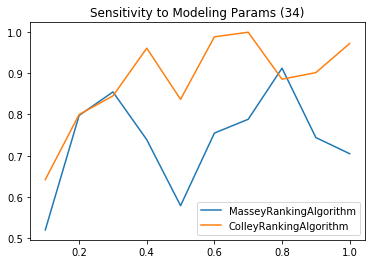

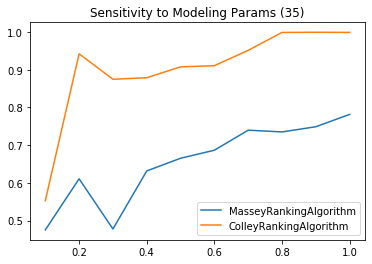

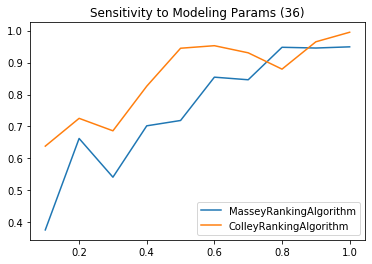

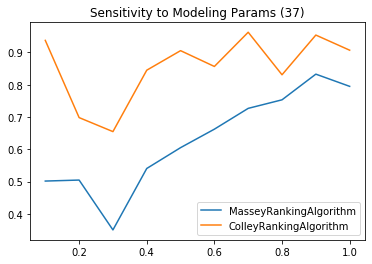

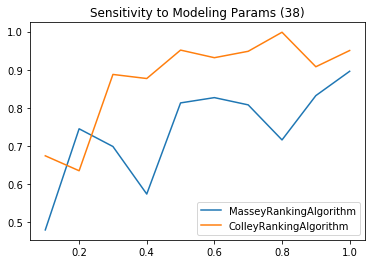

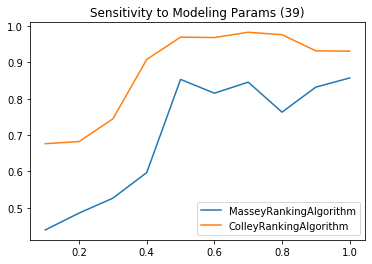

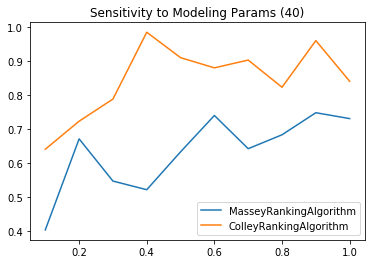

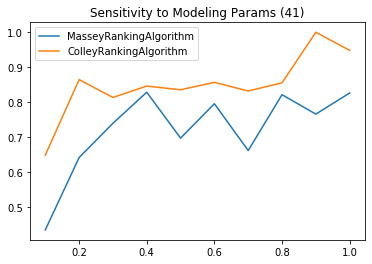

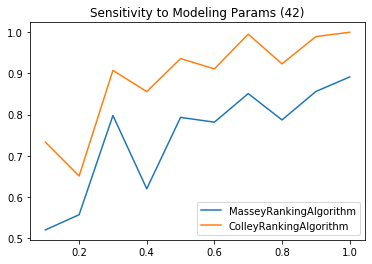

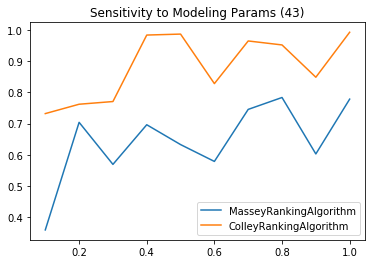

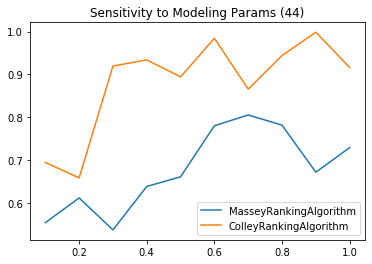

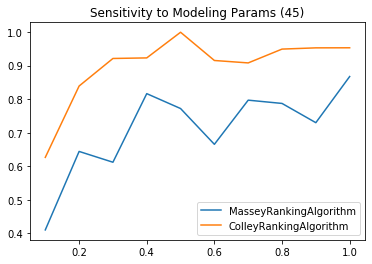

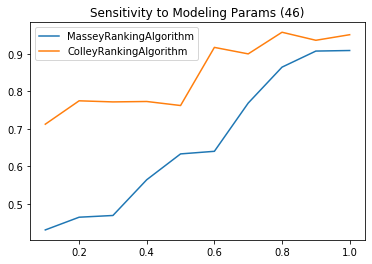

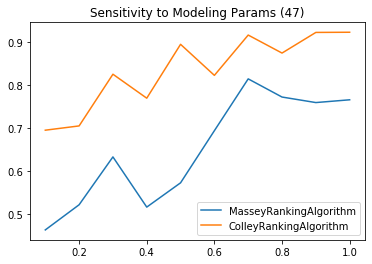

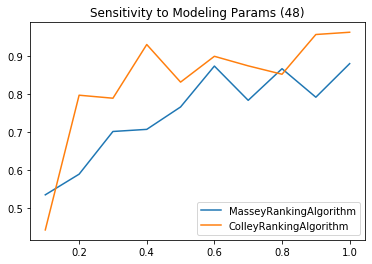

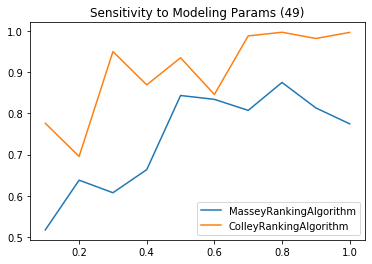

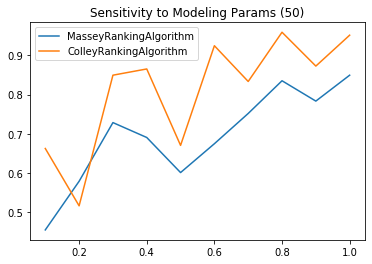

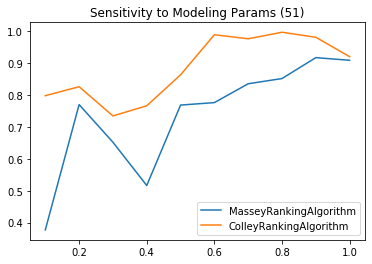

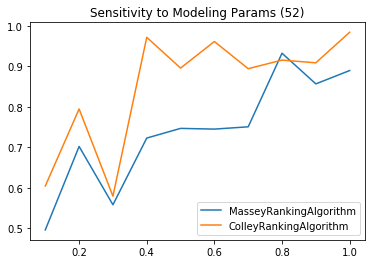

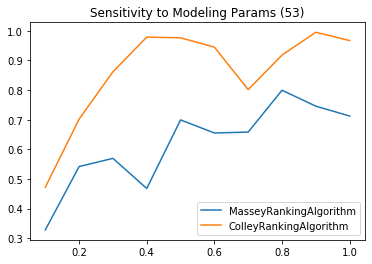

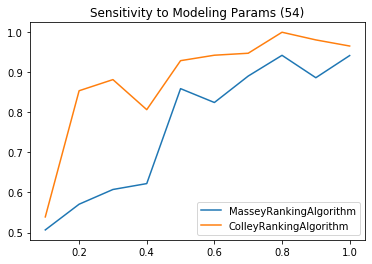

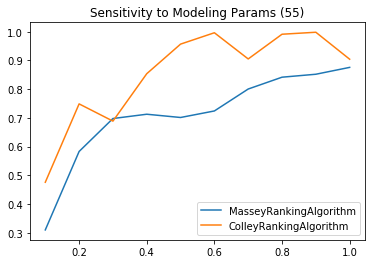

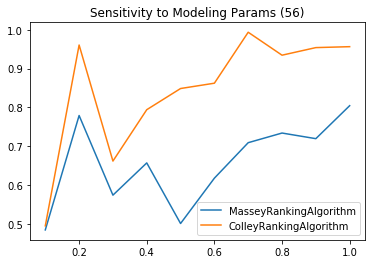

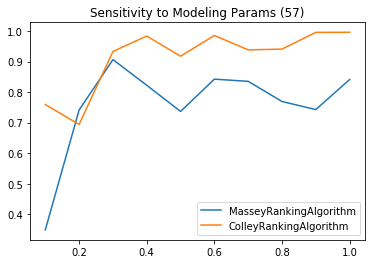

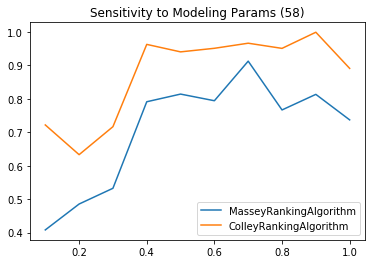

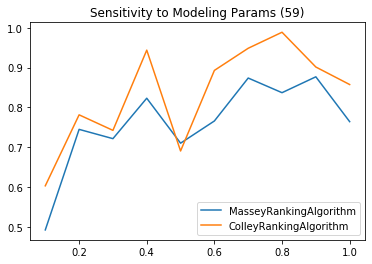

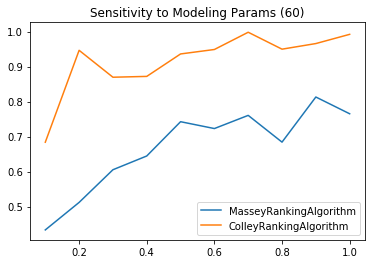

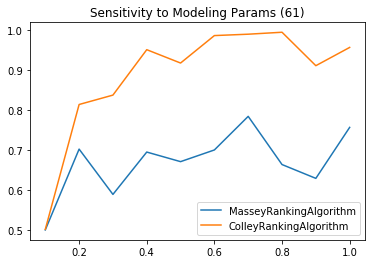

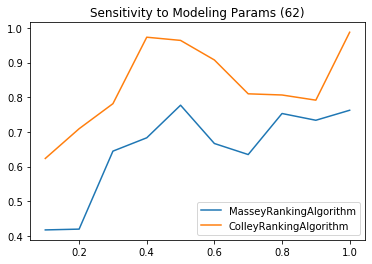

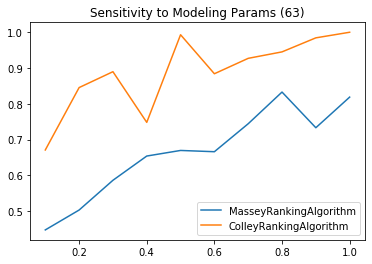

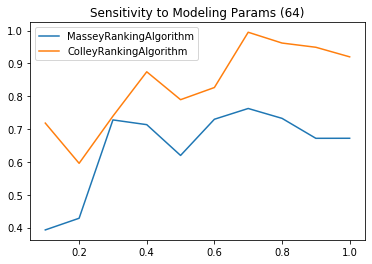

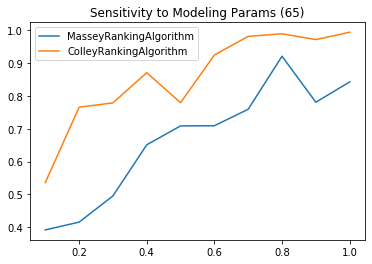

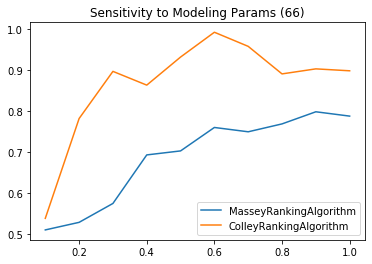

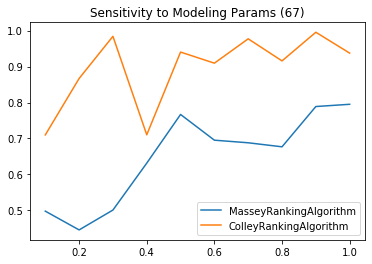

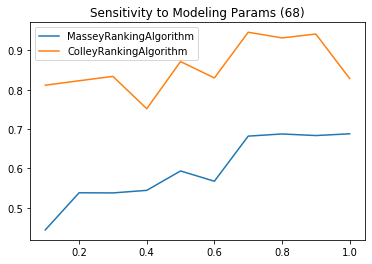

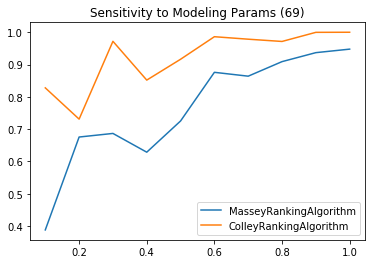

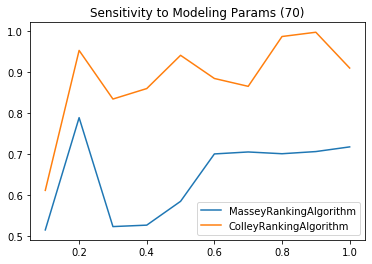

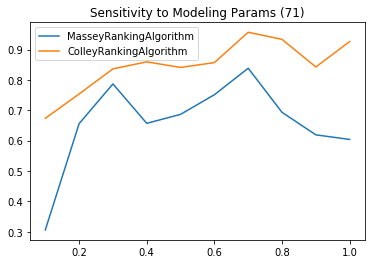

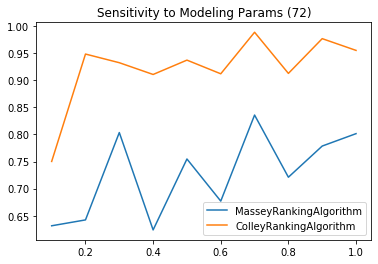

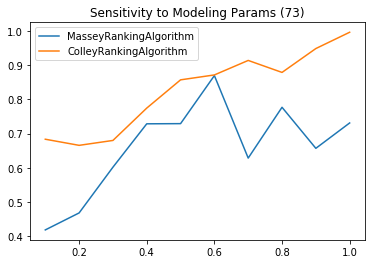

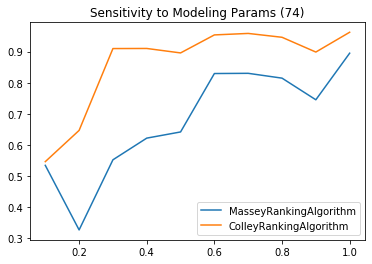

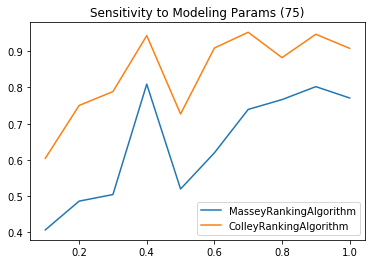

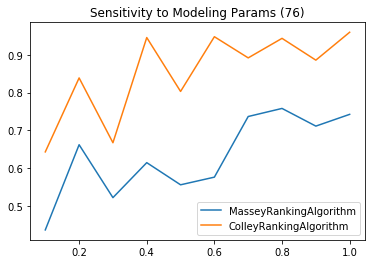

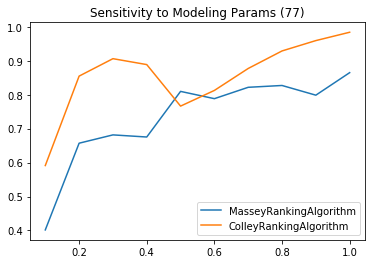

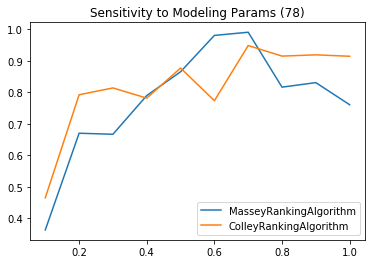

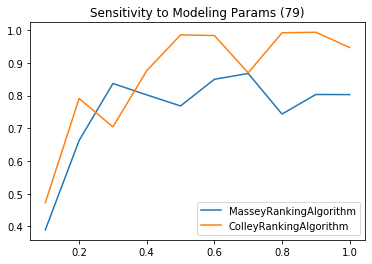

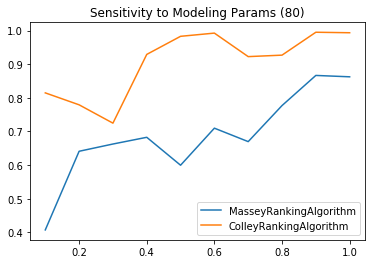

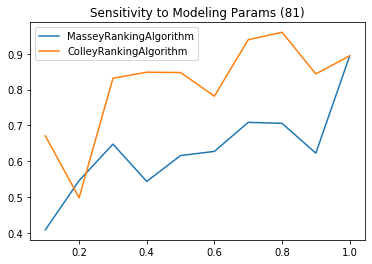

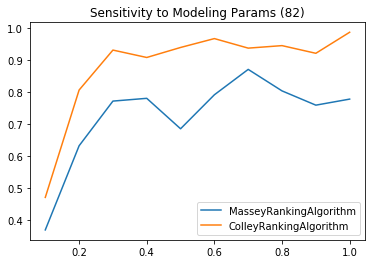

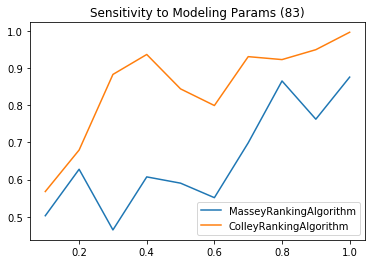

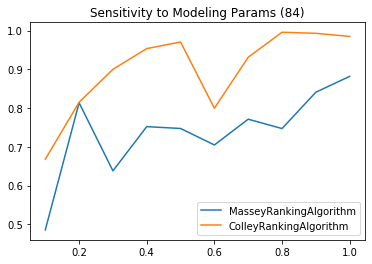

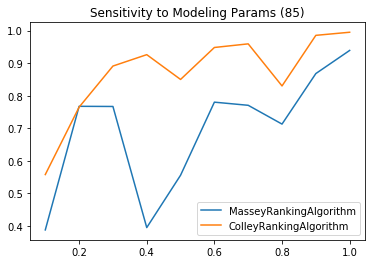

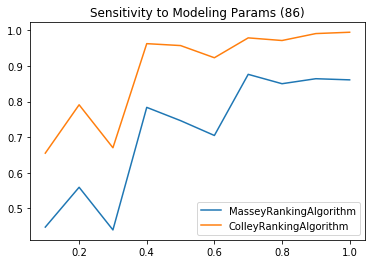

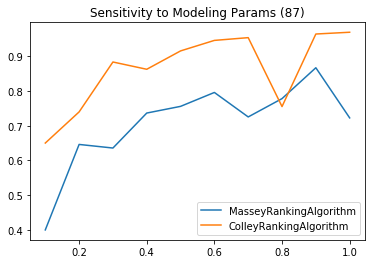

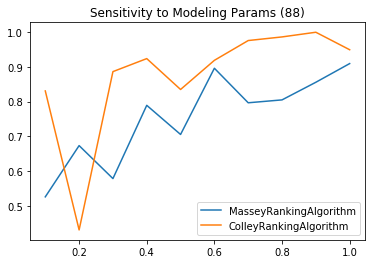

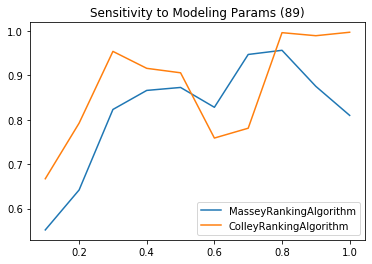

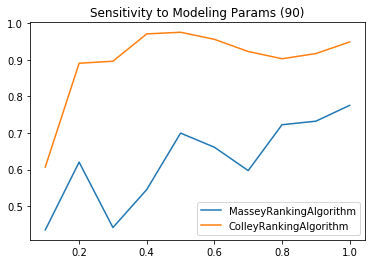

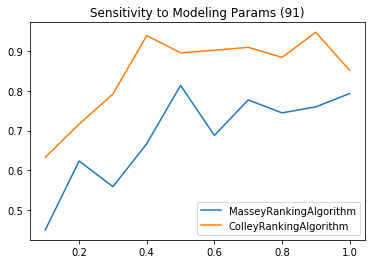

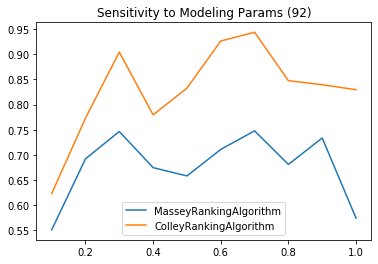

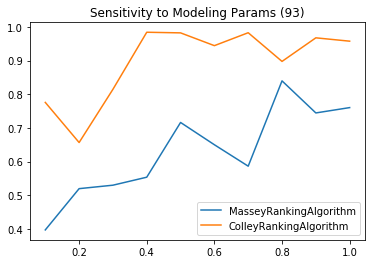

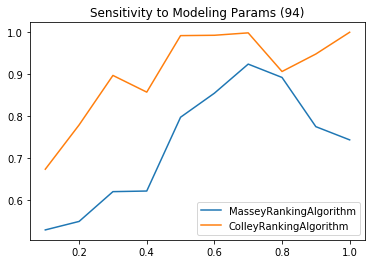

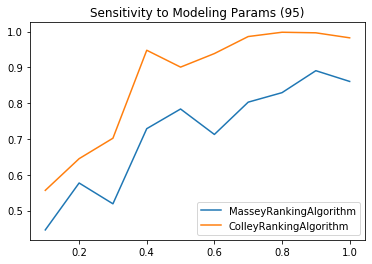

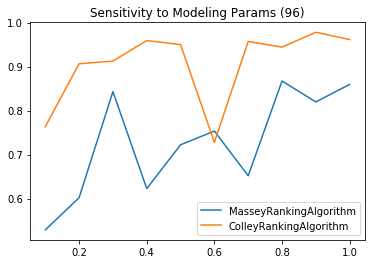

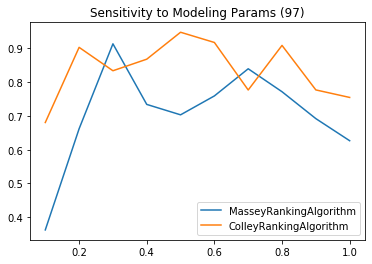

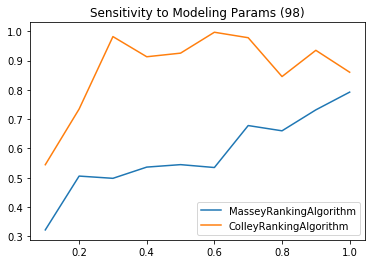

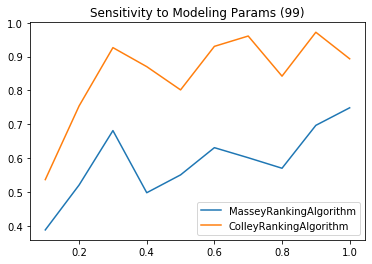

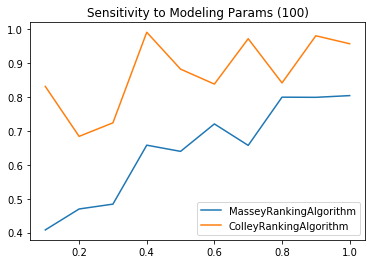

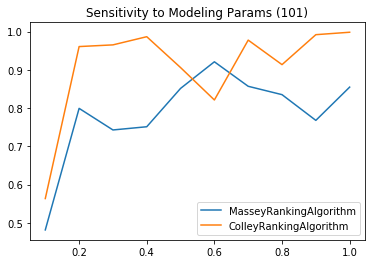

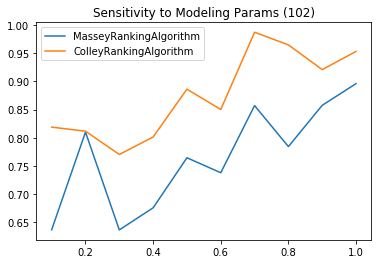

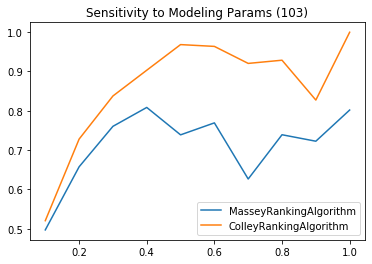

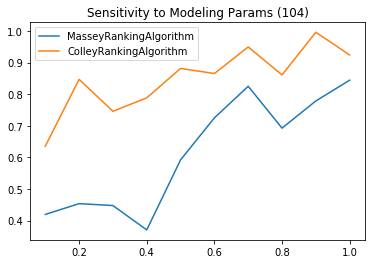

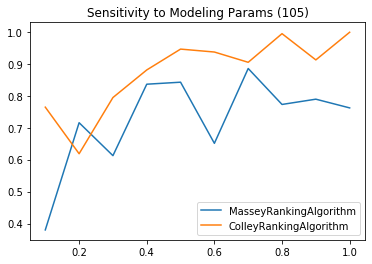

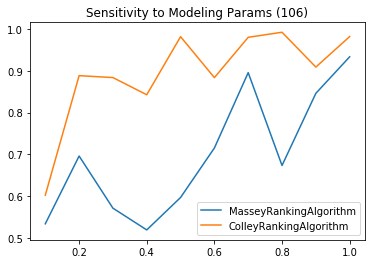

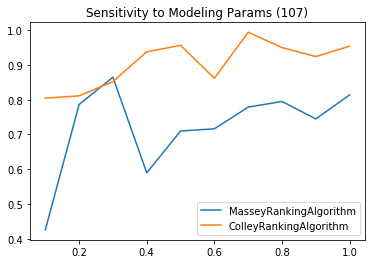

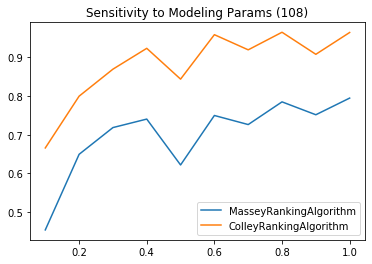

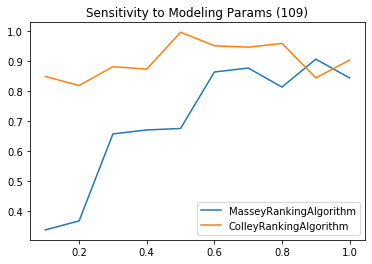

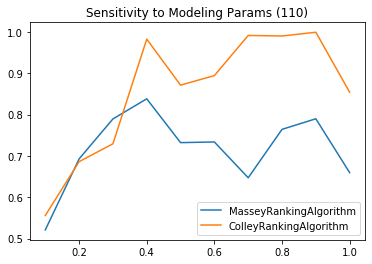

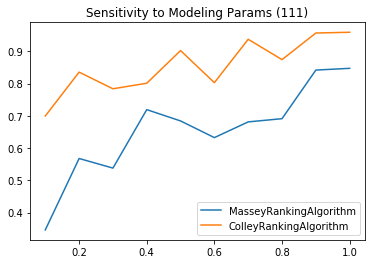

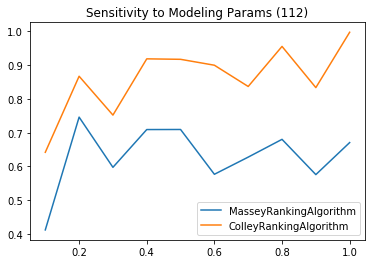

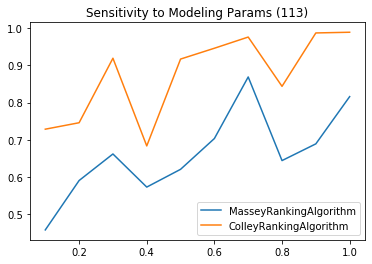

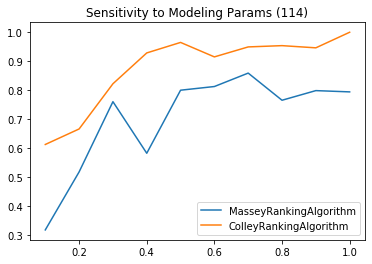

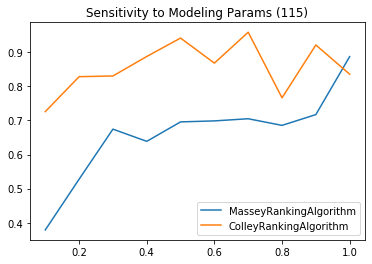

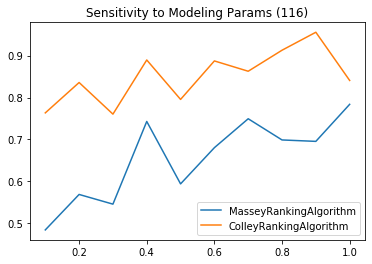

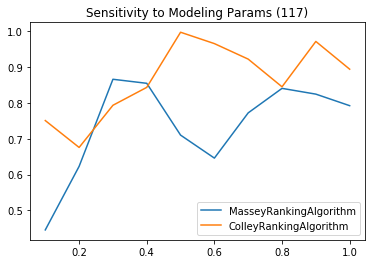

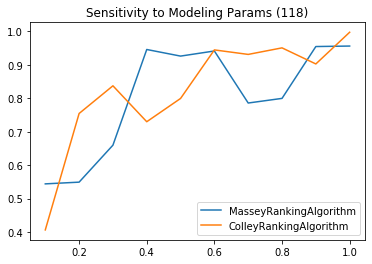

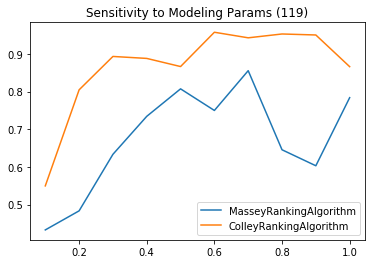

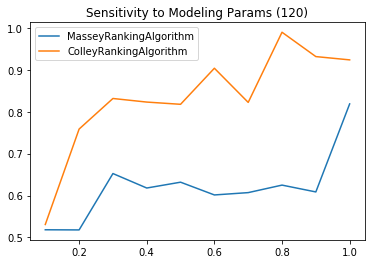

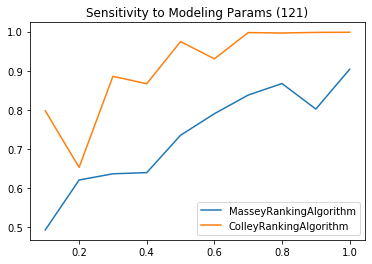

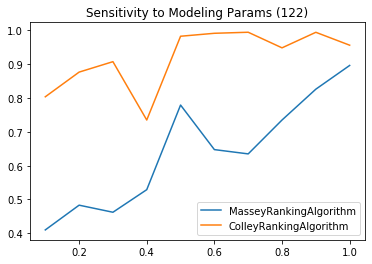

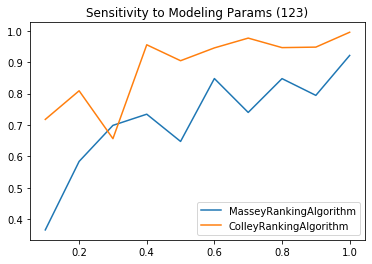

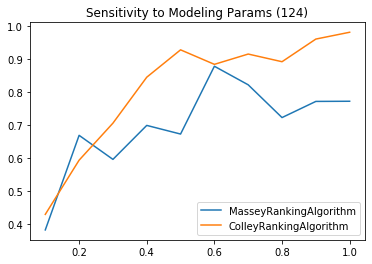

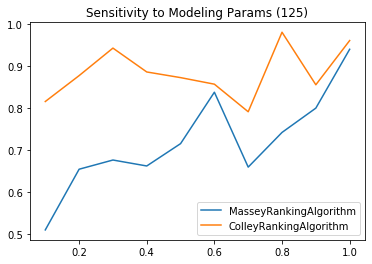

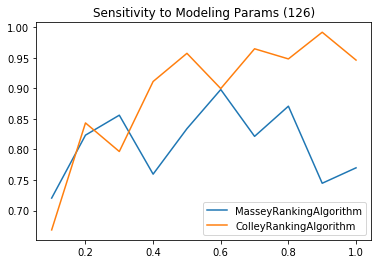

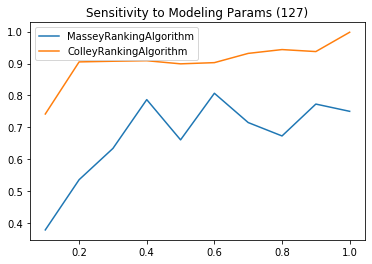

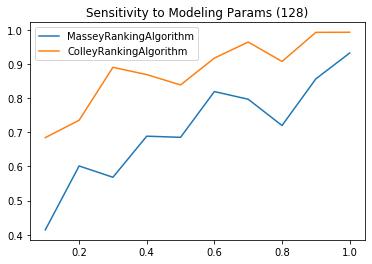

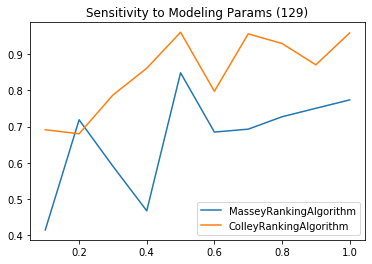

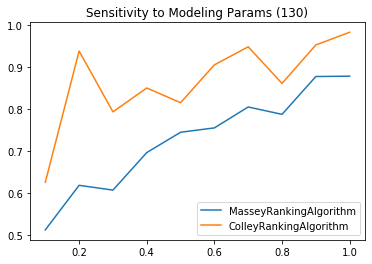

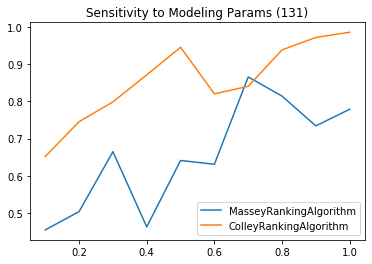

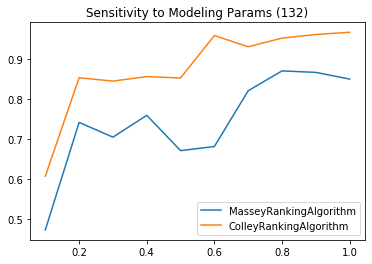

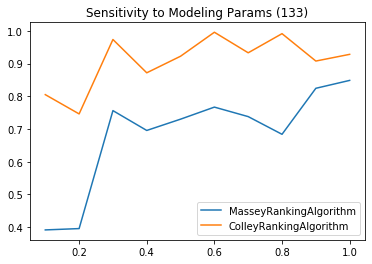

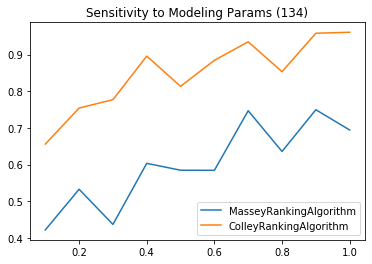

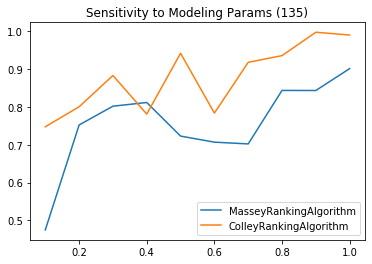

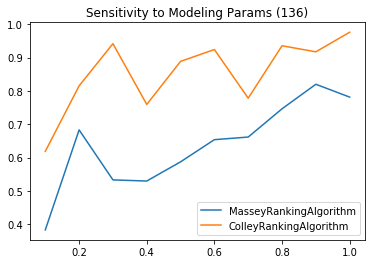

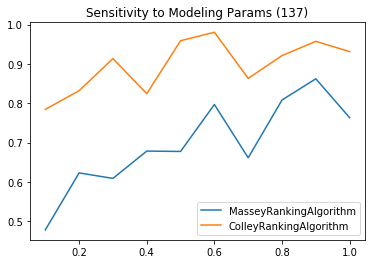

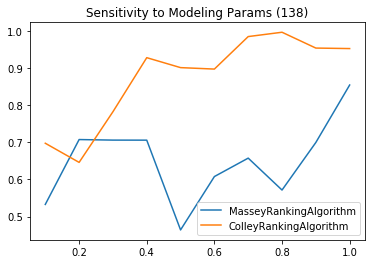

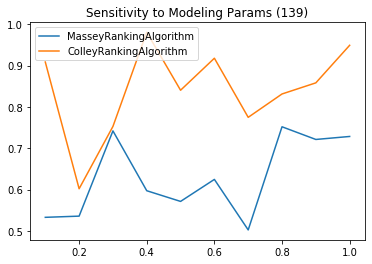

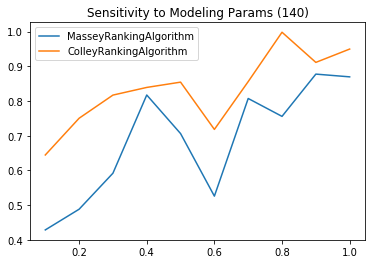

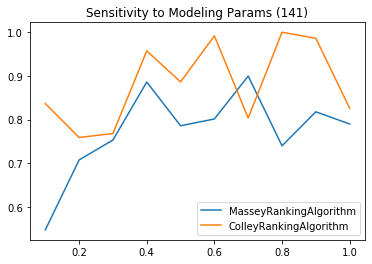

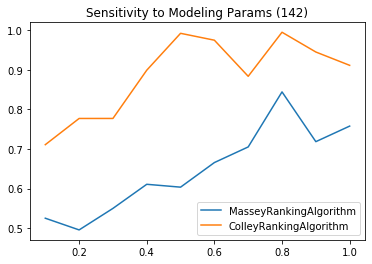

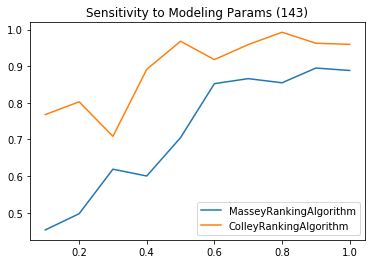

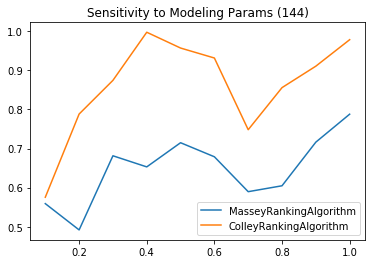

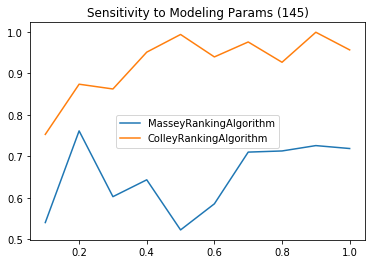

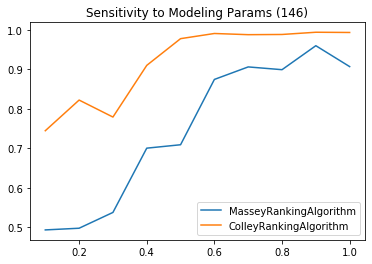

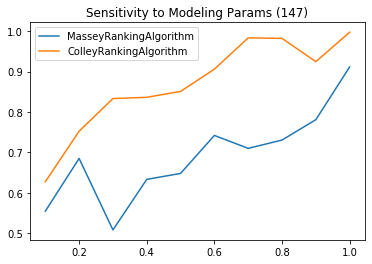

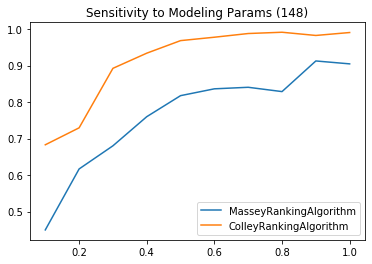

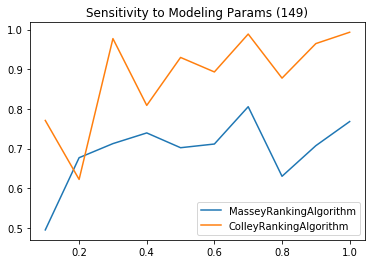

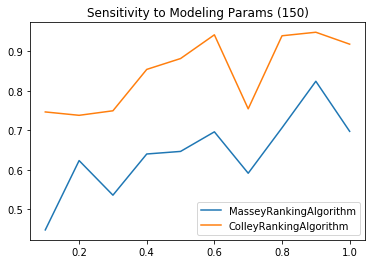

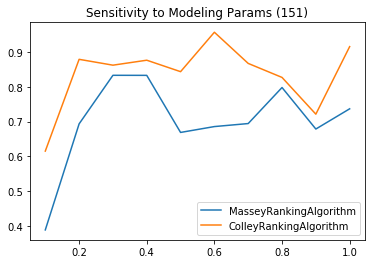

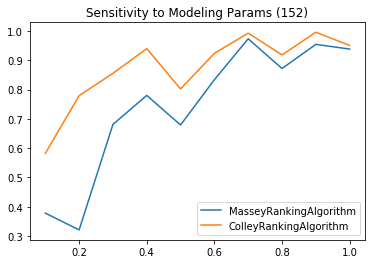

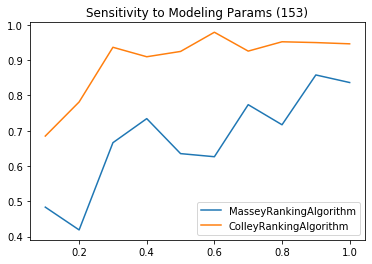

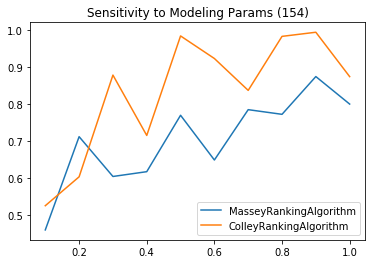

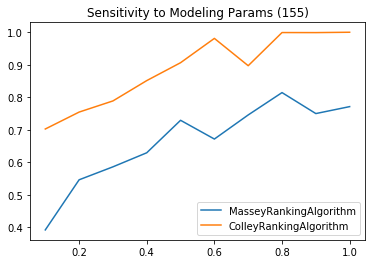

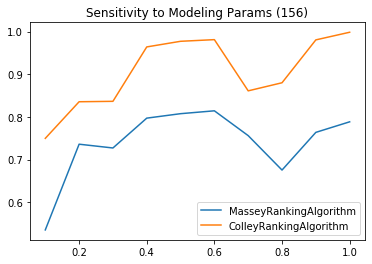

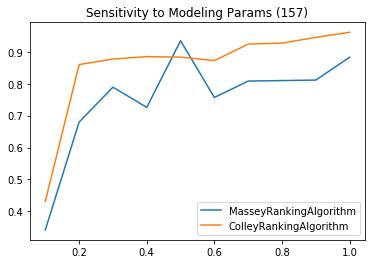

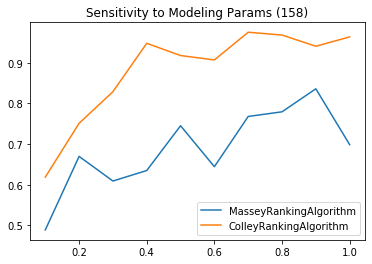

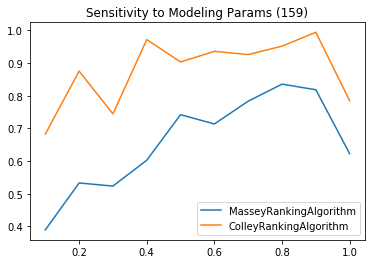

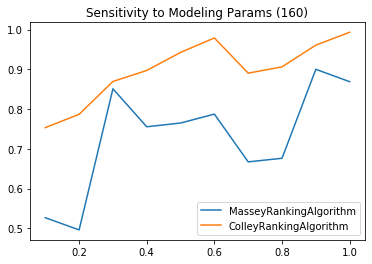

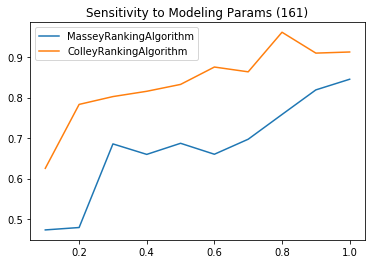

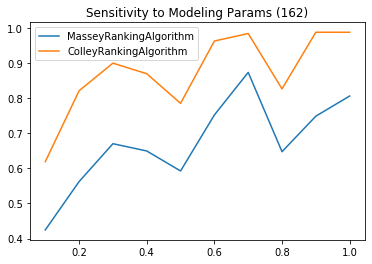

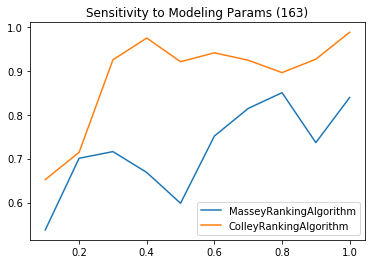

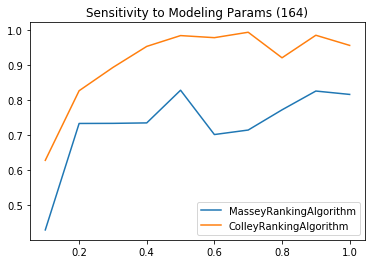

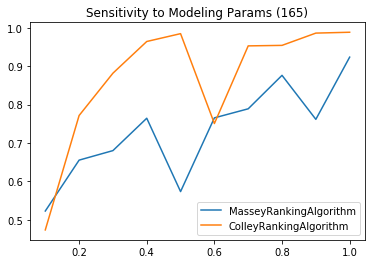

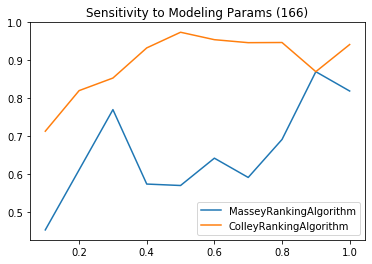

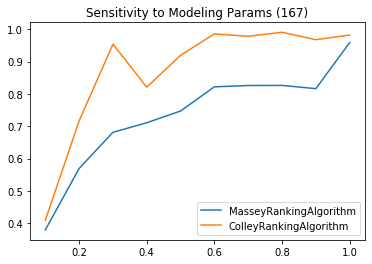

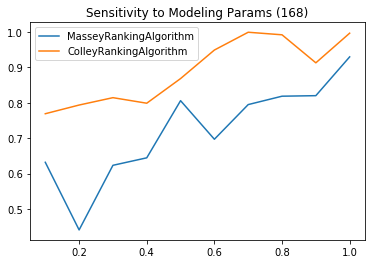

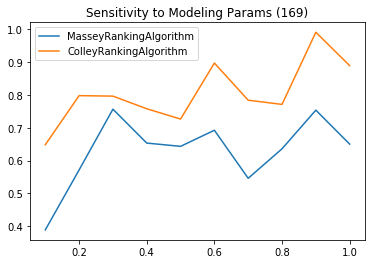

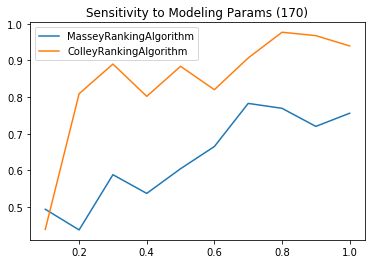

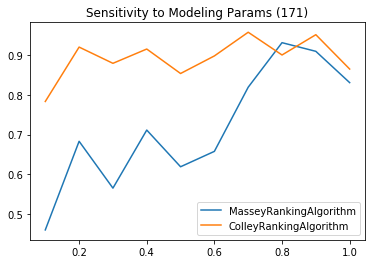

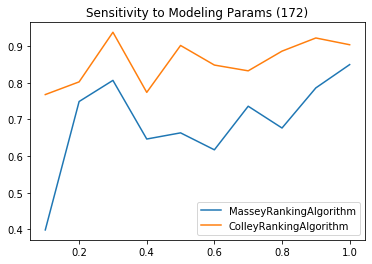

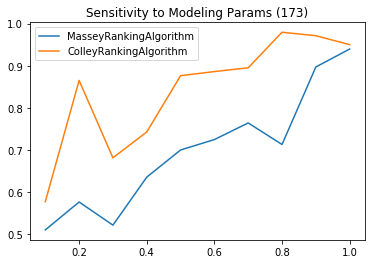

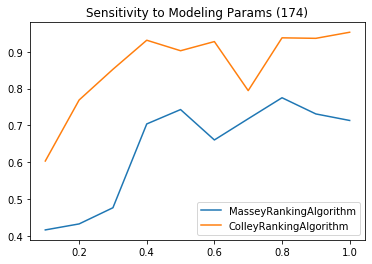

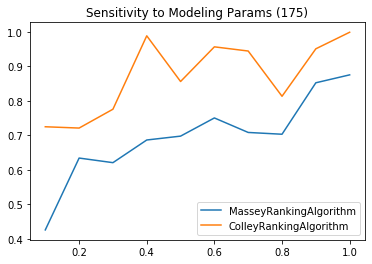

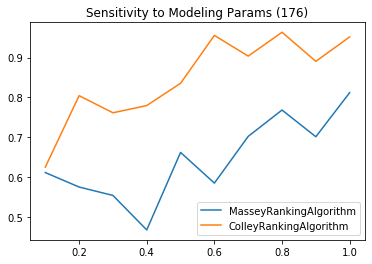

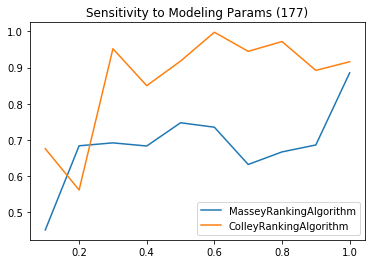

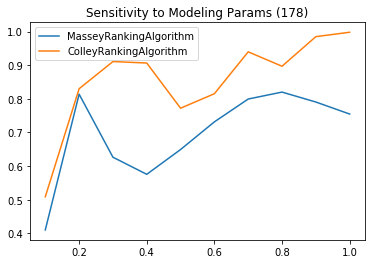

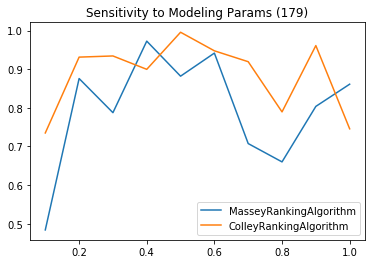

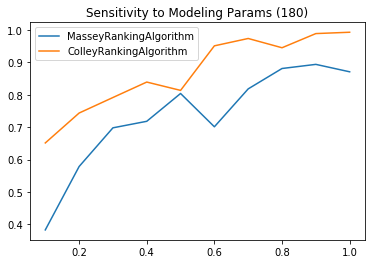

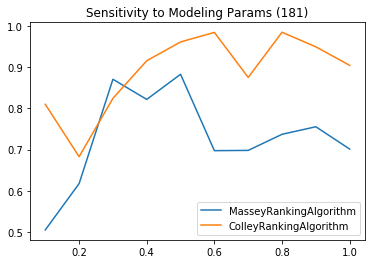

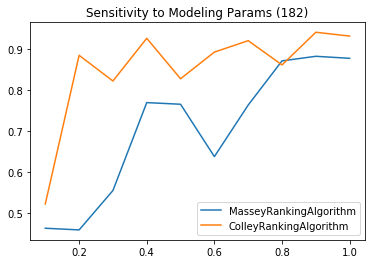

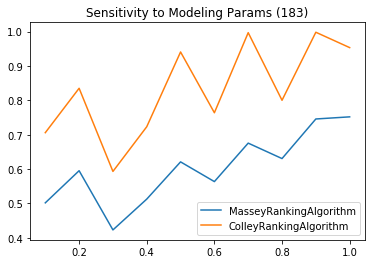

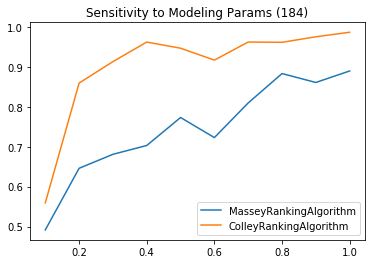

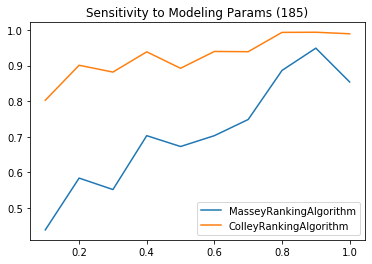

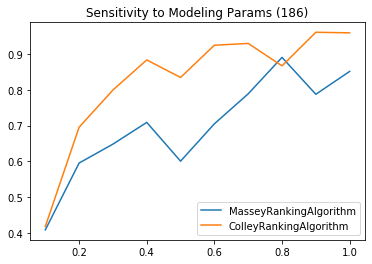

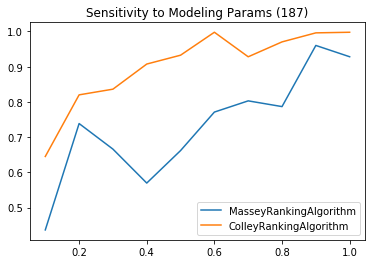

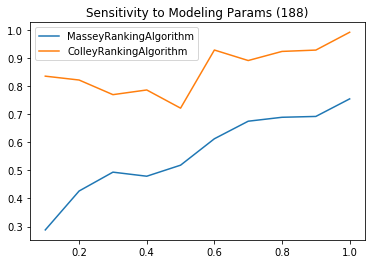

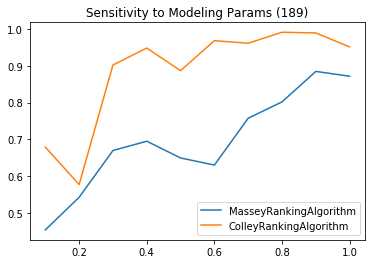

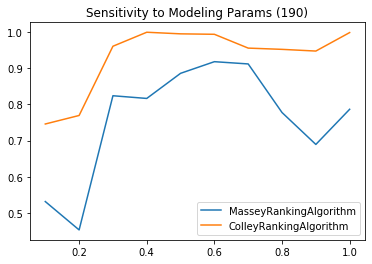

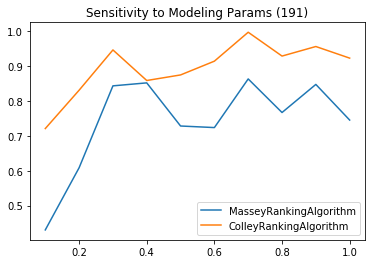

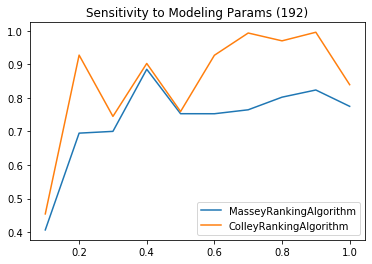

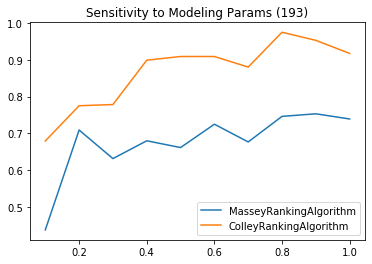

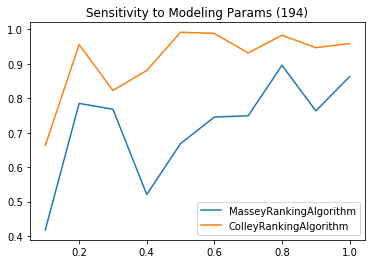

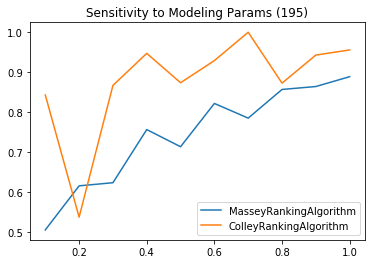

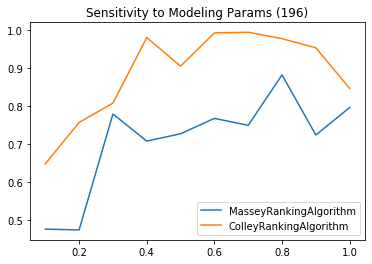

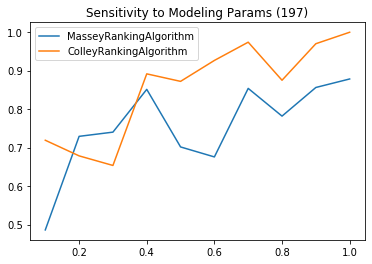

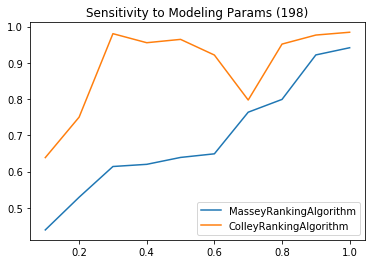

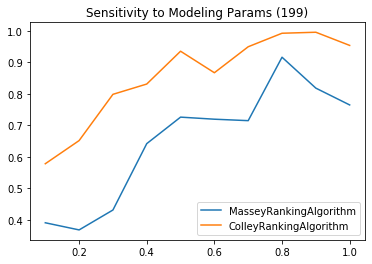

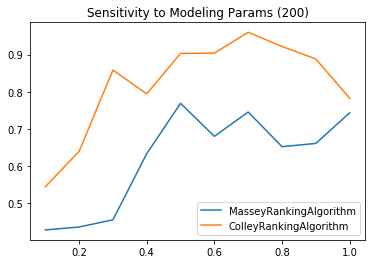

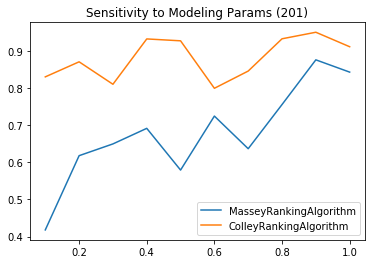

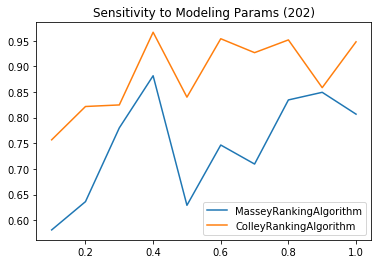

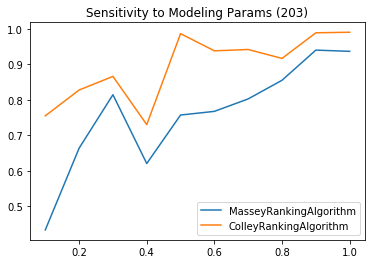

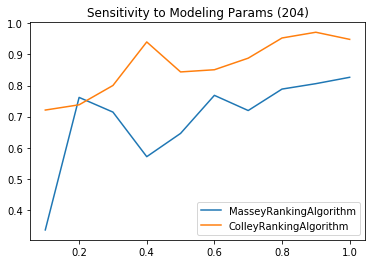

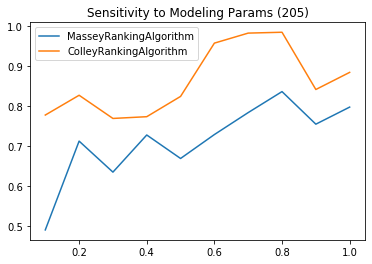

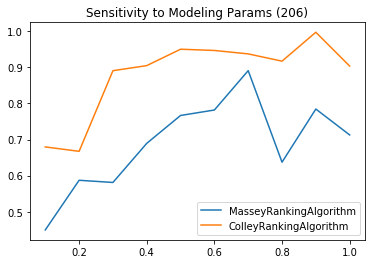

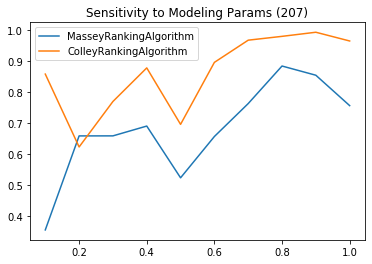

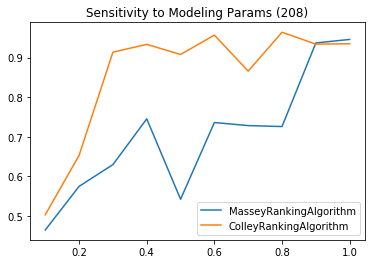

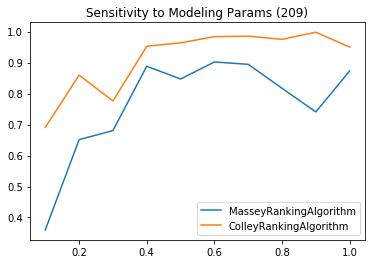

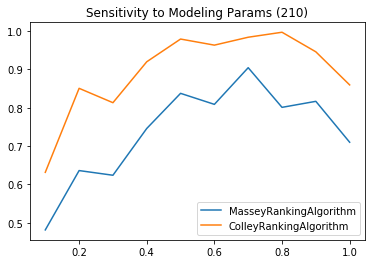

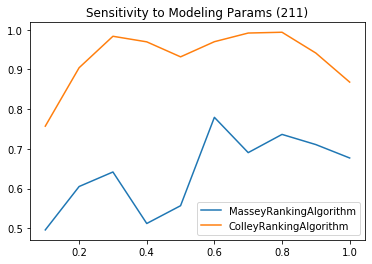

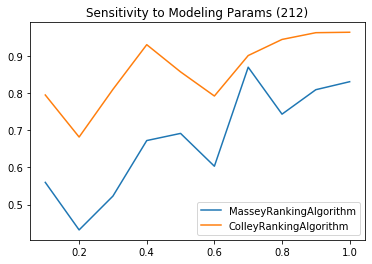

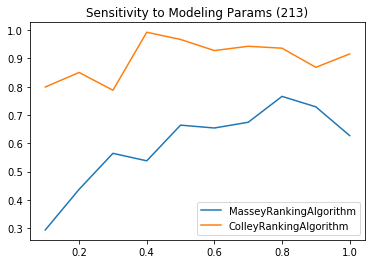

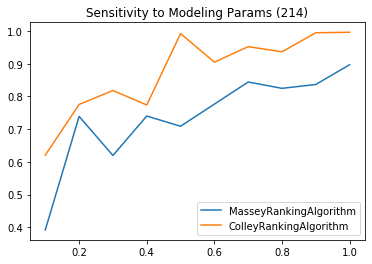

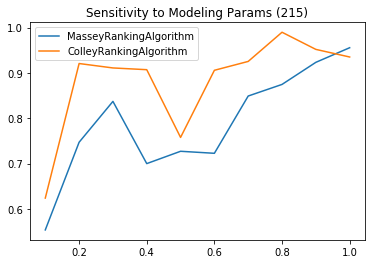

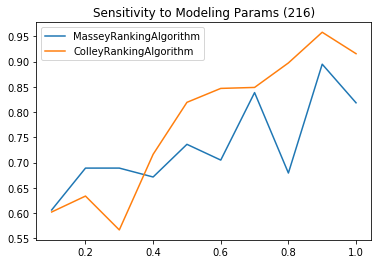

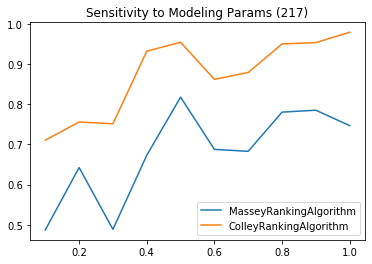

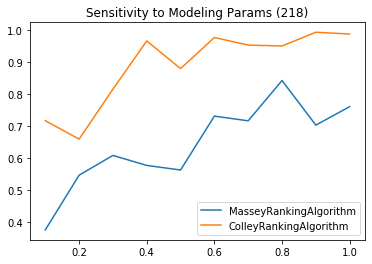

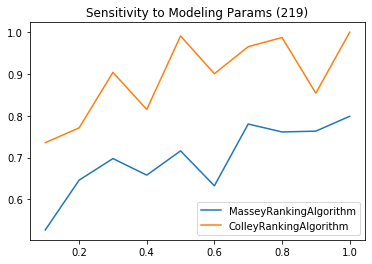

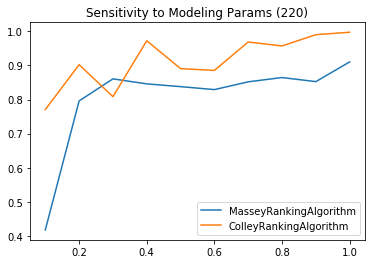

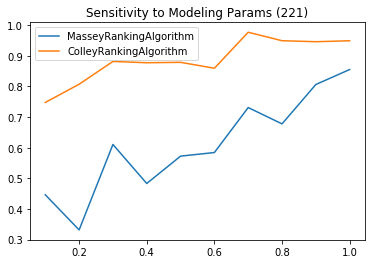

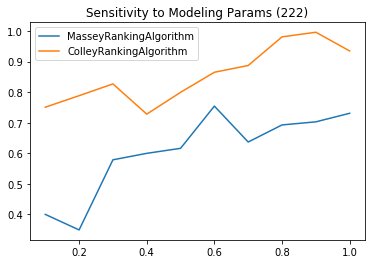

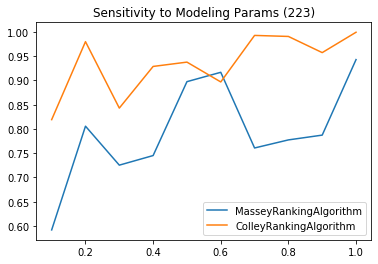

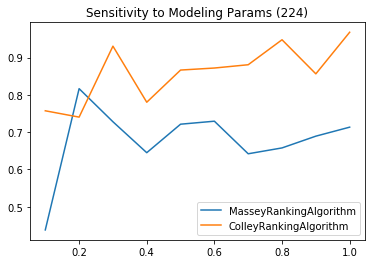

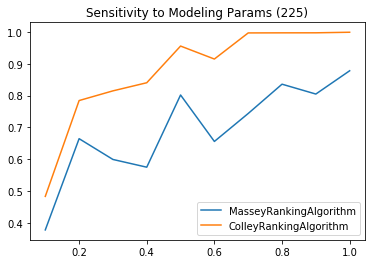

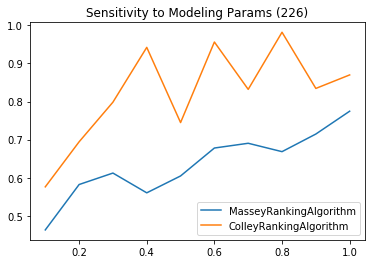

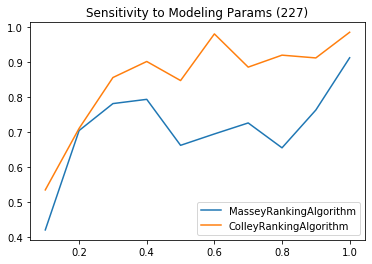

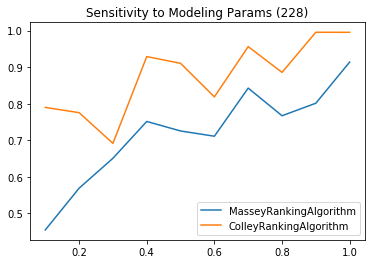

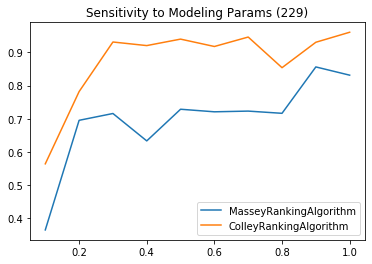

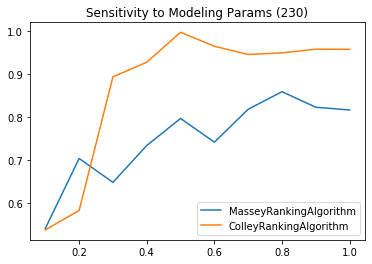

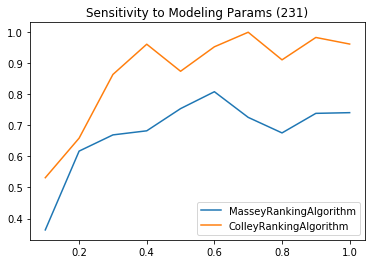

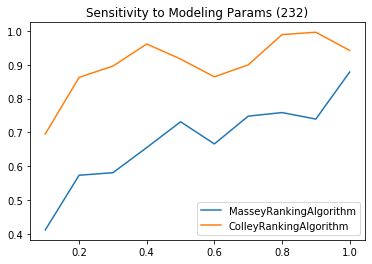

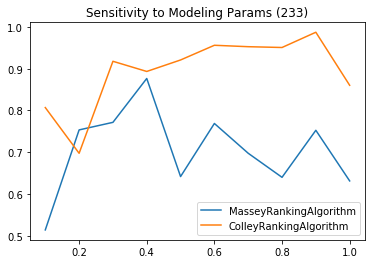

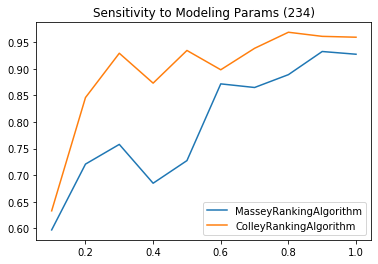

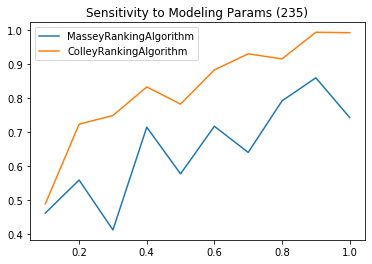

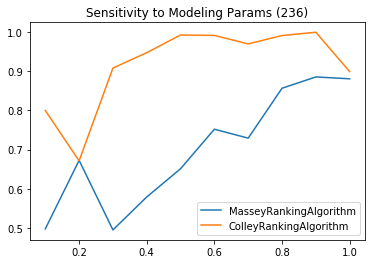

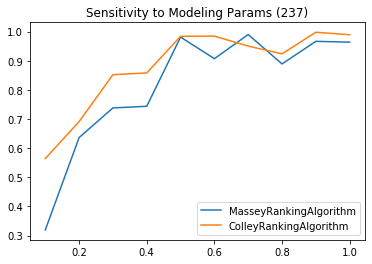

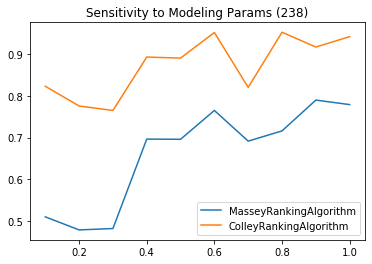

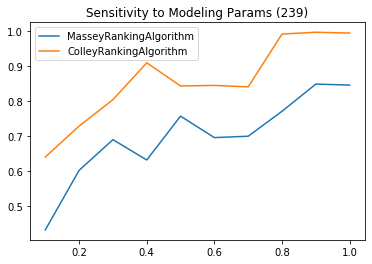

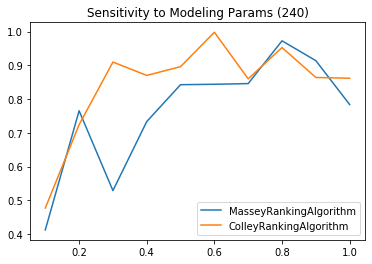

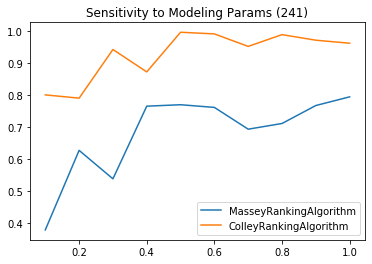

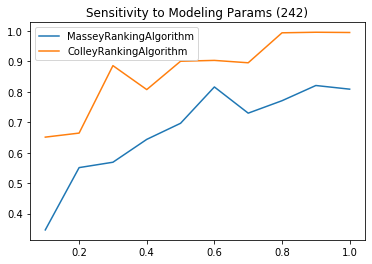

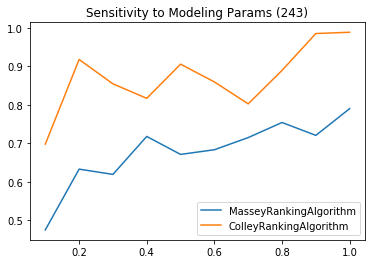

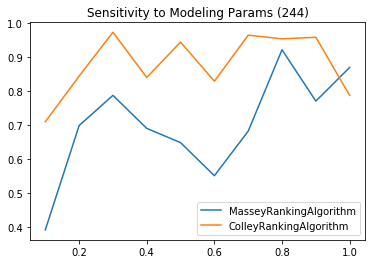

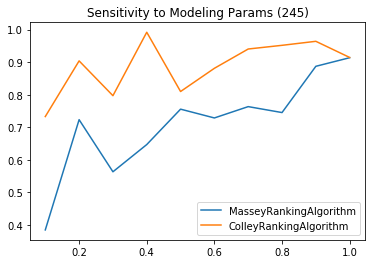

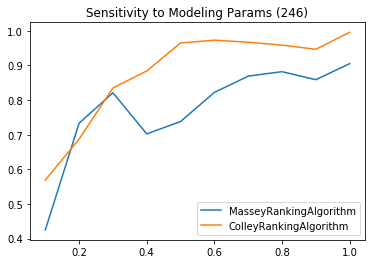

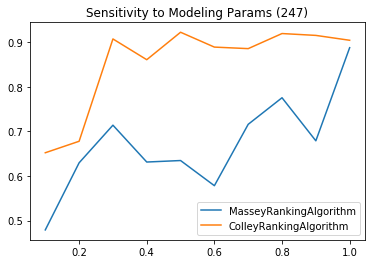

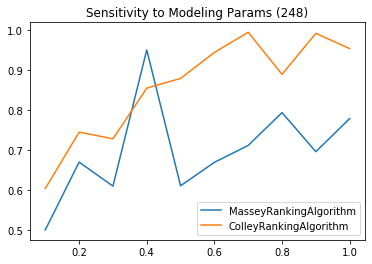

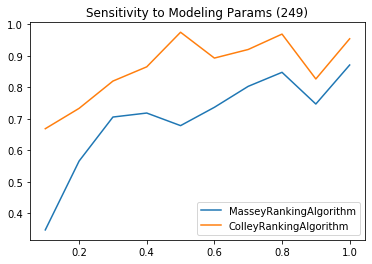

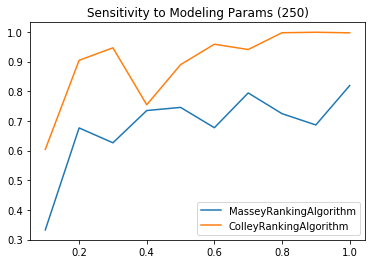

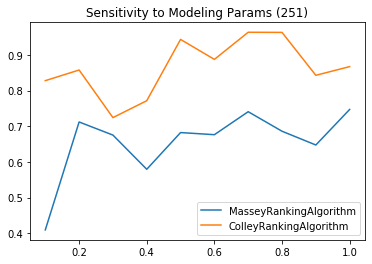

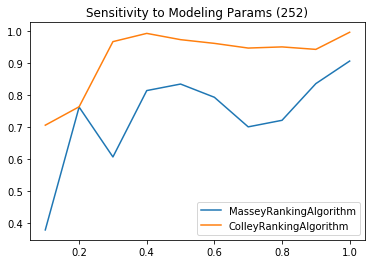

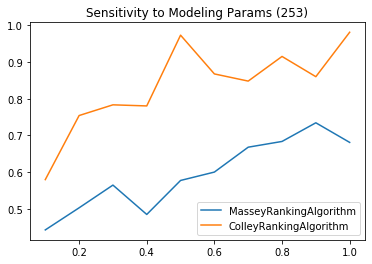

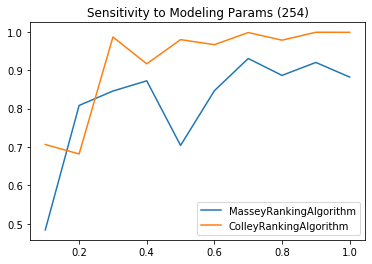

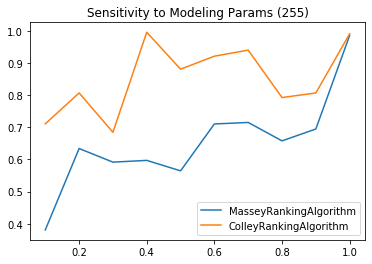

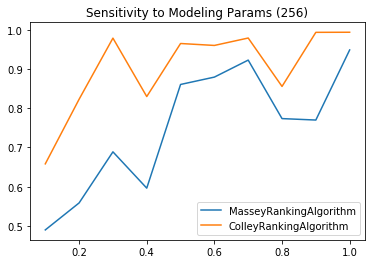

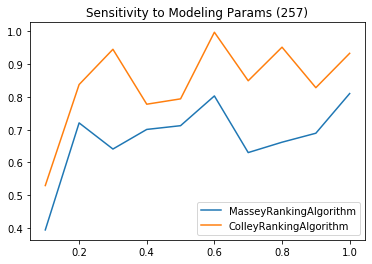

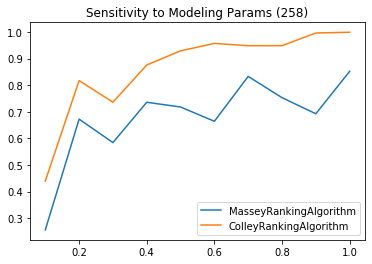

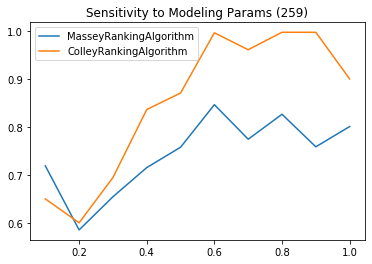

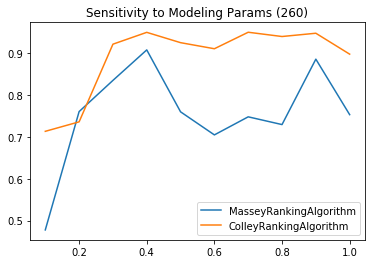

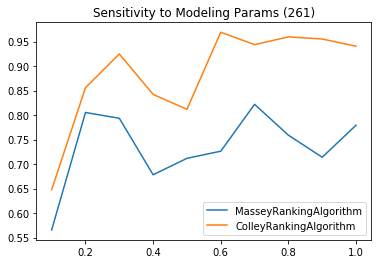

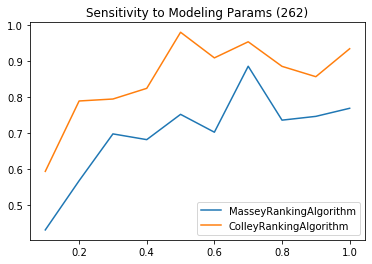

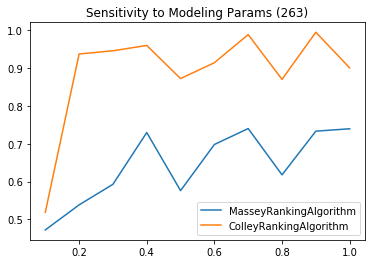

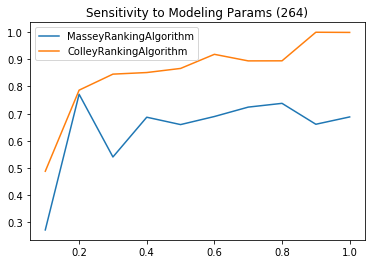

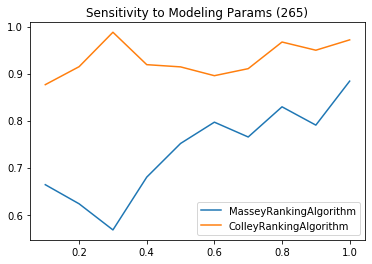

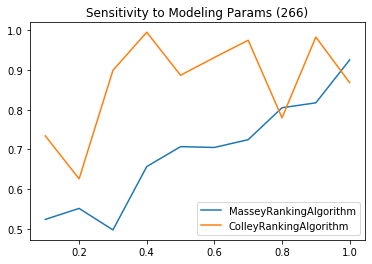

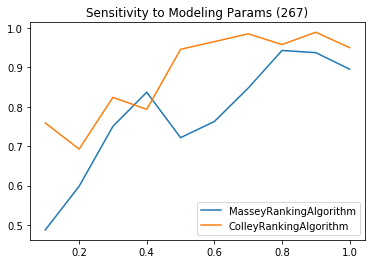

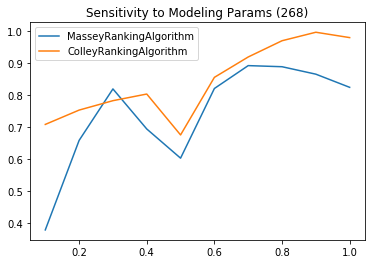

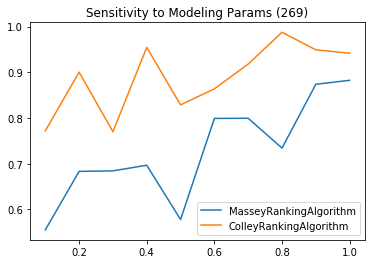

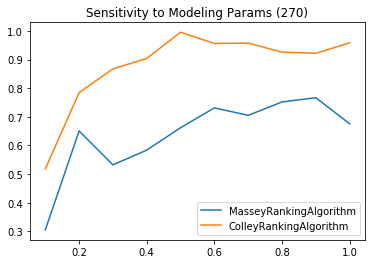

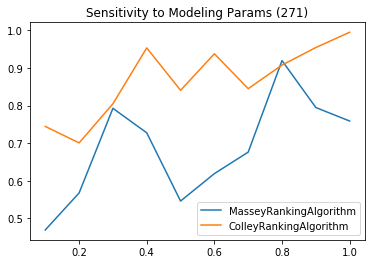

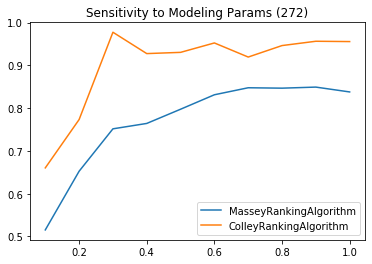

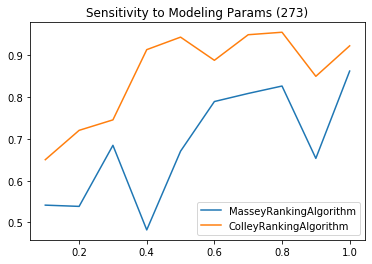

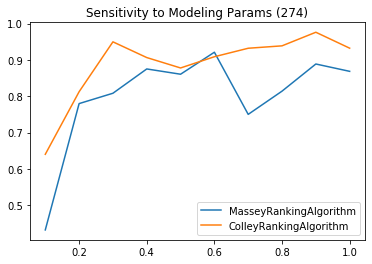

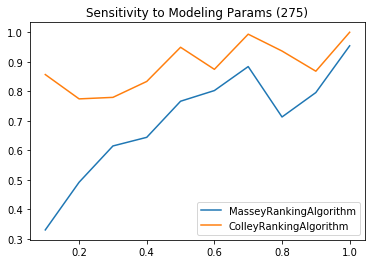

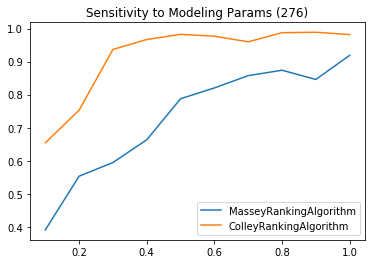

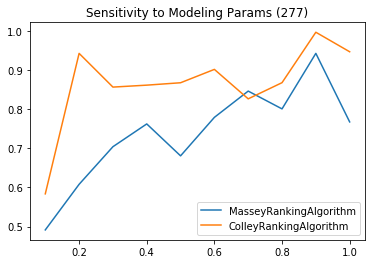

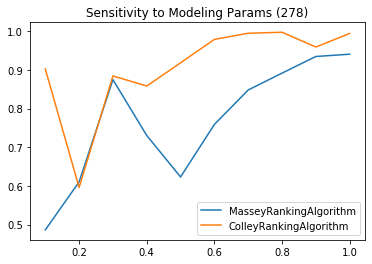

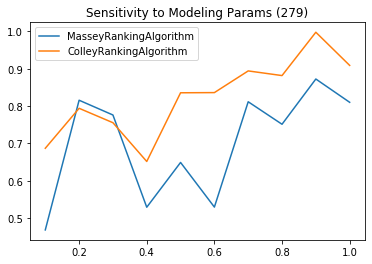

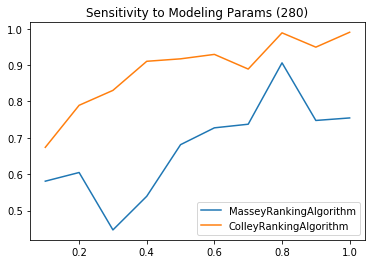

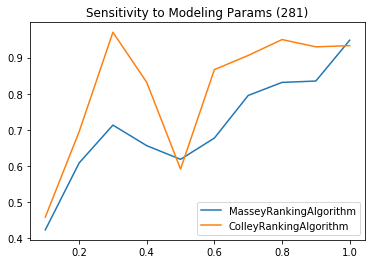

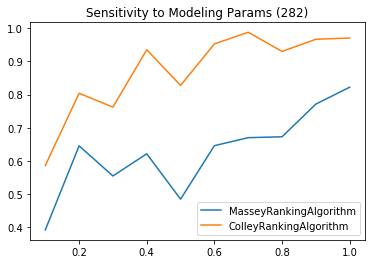

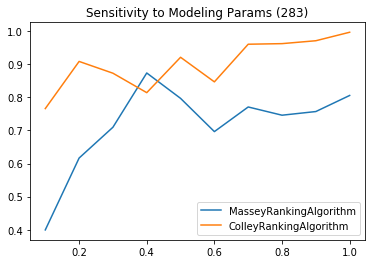

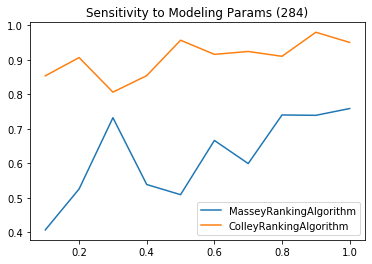

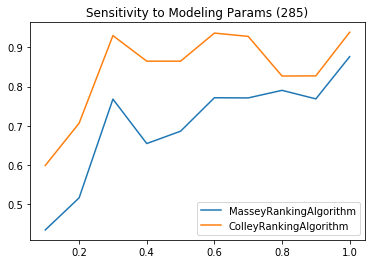

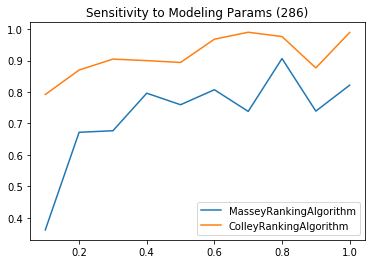

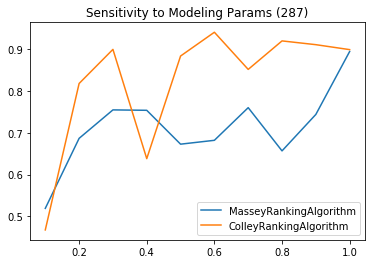

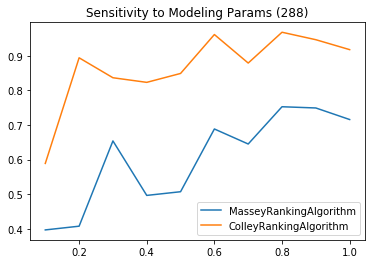

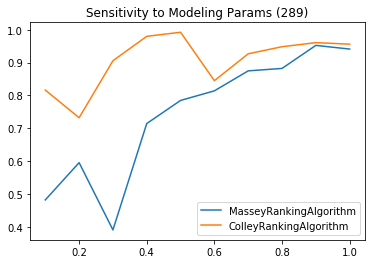

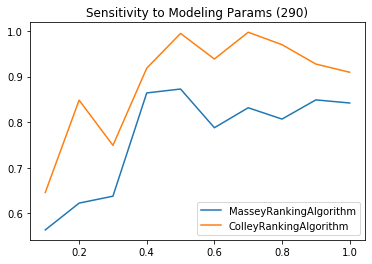

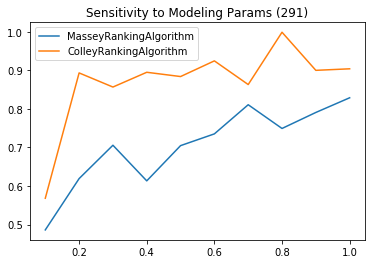

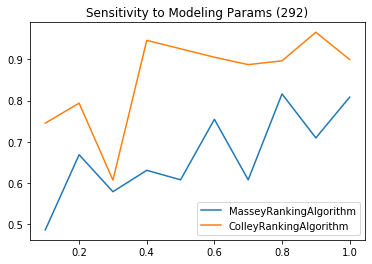

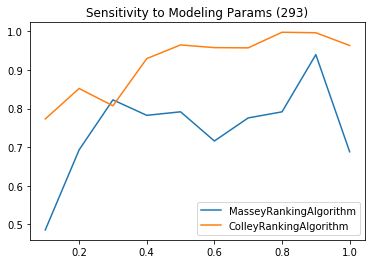

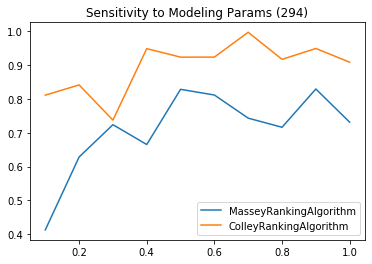

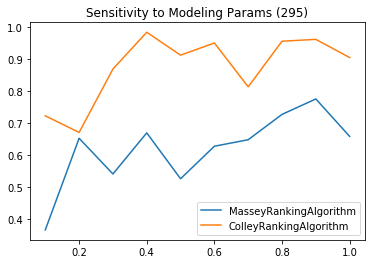

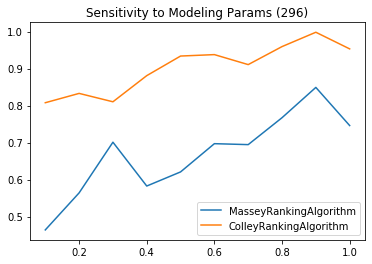

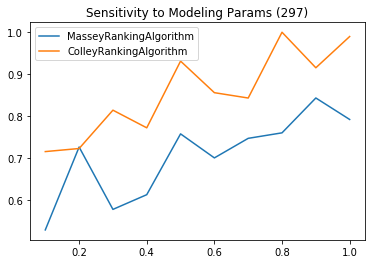

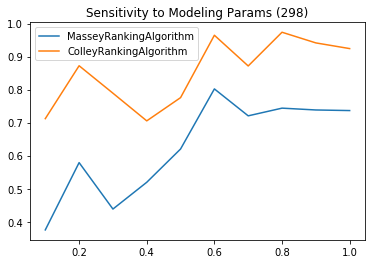

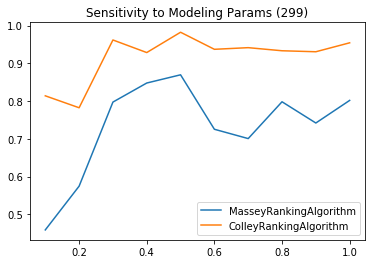

             w
frac          
0.1   0.451323
0.2   0.618147
0.3   0.648650
0.4   0.678230
0.5   0.700353
0.6   0.729871
0.7   0.762789
0.8   0.776078
0.9   0.793100
1.0   0.819175
             w
frac          
0.1   0.668446
0.2   0.778551
0.3   0.841046
0.4   0.881987
0.5   0.899099
0.6   0.914715
0.7   0.929825
0.8   0.934585
0.9   0.947927
1.0   0.948039


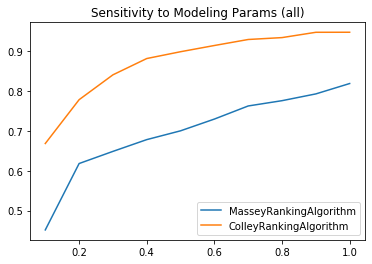

In [12]:
# For each season
for yr in df["fp"].unique():
    for method in df["method"].unique():
        data = df.loc[(df.fp==yr)&(df.method==method), ["frac", "w"]]
        plt.plot(data.frac, data.w, label=method)
    plt.title("Sensitivity to Modeling Params ({})".format(yr))
    plt.legend()
    plt.show()

    # Aggregating seasons
for method in df["method"].unique():
    data = df.loc[(df.method==method), ["frac", "w"]].groupby("frac").mean()
    print(data)
    plt.plot(data.index, data.w, label=method)
plt.title("Sensitivity to Modeling Params (all)")
plt.legend()
plt.show()

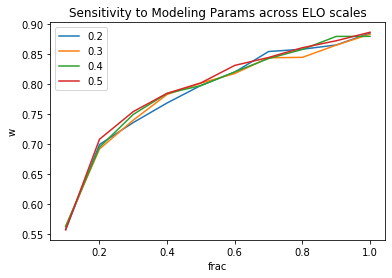

In [13]:
for scale in df.elo_scale.unique():
    subset = df.loc[(df.elo_scale==scale), ["frac", "w"]].groupby("frac").mean()
    plt.plot(subset.index, subset.w, label=str(scale))
plt.title("Sensitivity to Modeling Params across ELO scales")
plt.legend()
plt.ylabel("w")
plt.xlabel("frac")
plt.show()

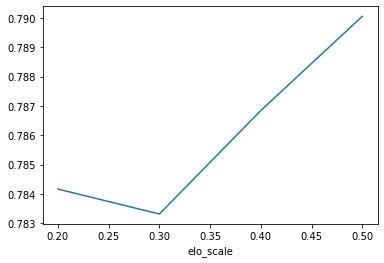

In [14]:
df.groupby("elo_scale")["w"].mean().plot()

In [15]:
prev_sensitivity = pd.read_csv("sensitivity_to_modeling_parameters.csv")

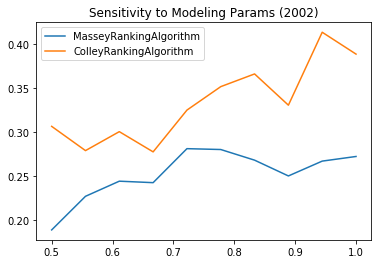

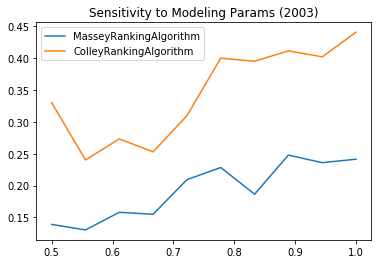

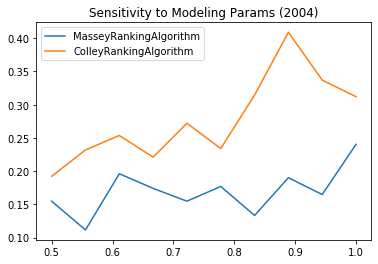

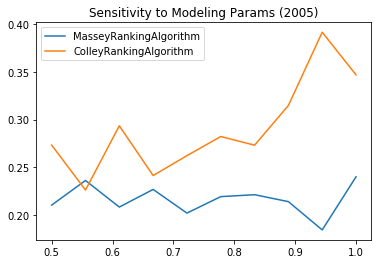

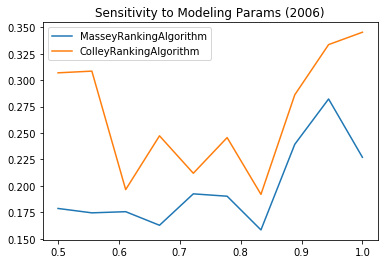

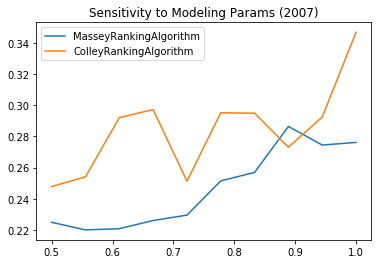

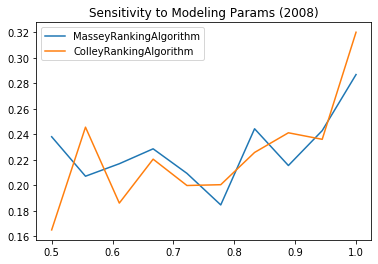

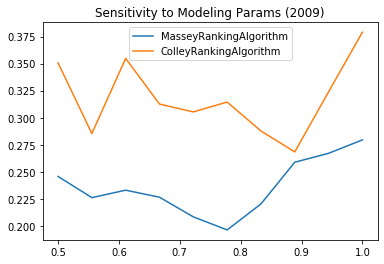

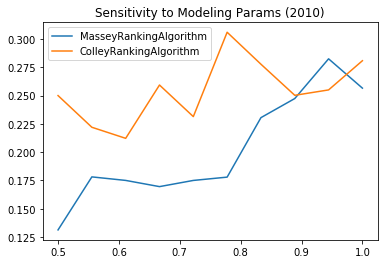

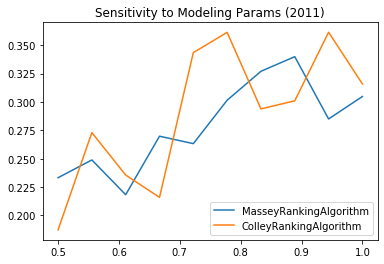

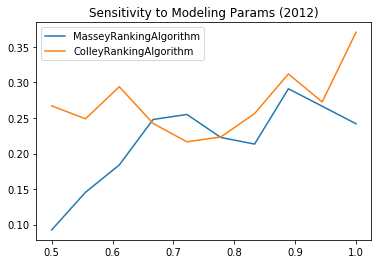

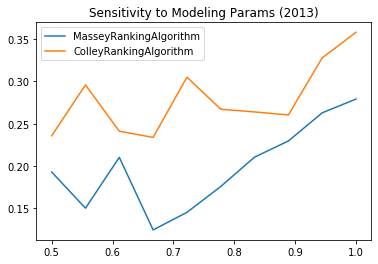

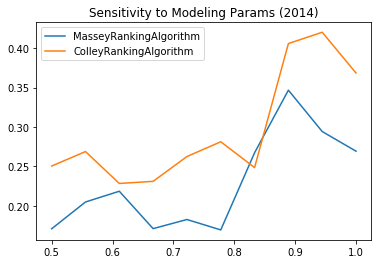

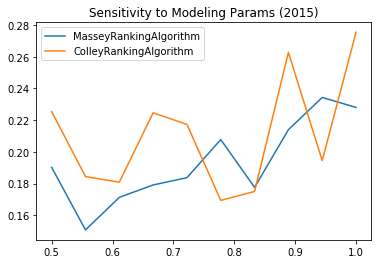

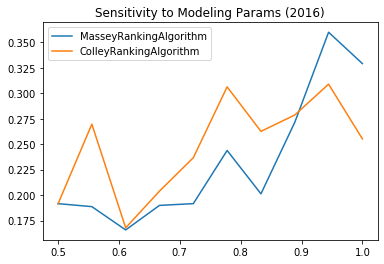

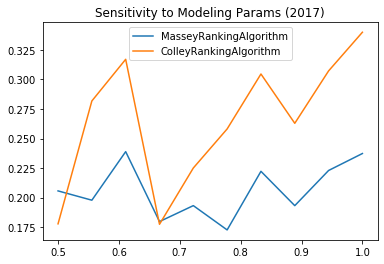

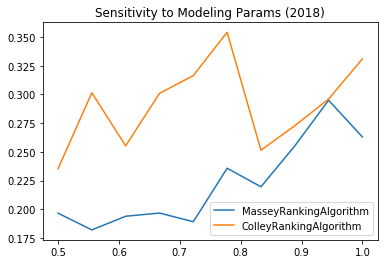

In [16]:
for yr in prev_sensitivity["fp"].unique():
    for method in df["method"].unique():
        data = prev_sensitivity.loc[(prev_sensitivity.fp==yr)&(prev_sensitivity.method==method), ["frac", "w"]]
        plt.plot(data.frac, data.w, label=method)
    plt.title("Sensitivity to Modeling Params ({})".format(yr))
    plt.legend()
    plt.show()